In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameter setup

Plotting

In [27]:
inferno_r = matplotlib.cm.inferno_r
cmap_hist = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)

## Load data

In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = '_elementary'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/scalar_TNG100-1_elementary.yaml


In [4]:
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

# Load in objects; need no matter what feature type
sim_reader = SimulationReader(halo_params['sim']['base_dir'], halo_params['sim']['sim_name'], 
                              halo_params['sim']['sim_name_dark'], halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(halo_params['halo']['fn_dark_halo_arr'])
sim_reader.read_simulations() # TODO: do we need this step?

In [5]:
x_scalars, x_scalars_extra = utils.load_features('scalars', sim_reader, fn_scalar_config=fn_scalar_config)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
loading scalar features
loaded


In [9]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

In [10]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

# M stellar

In [50]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.npy'

In [51]:
y_pred = np.load(fn_pred)

In [52]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

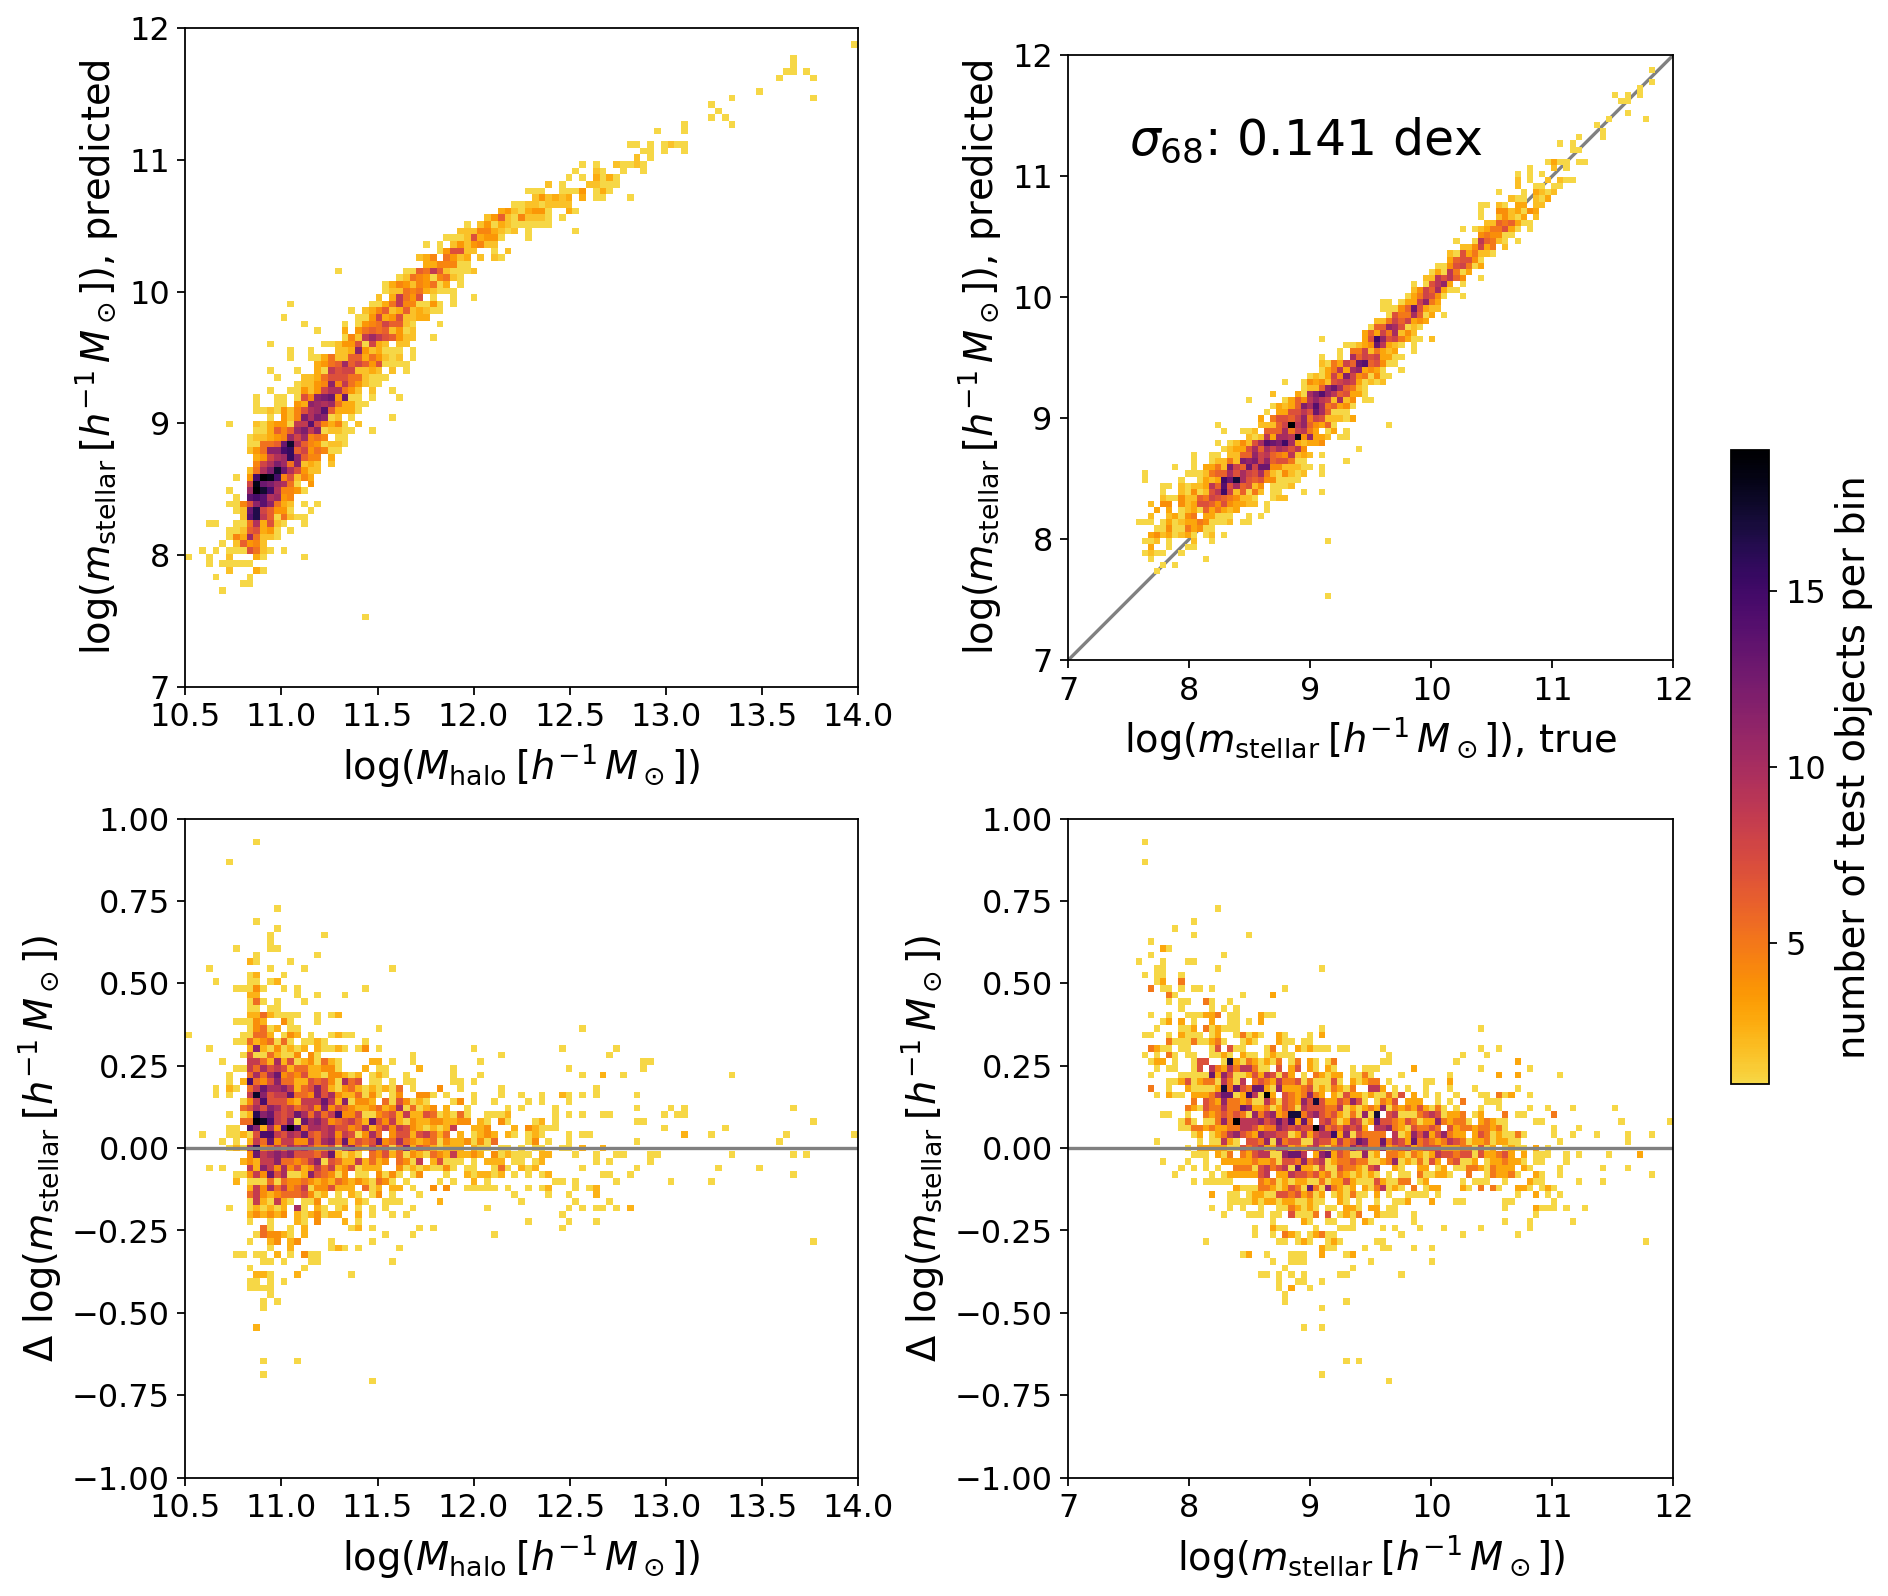

In [53]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test_mult, y_pred_mult, 
                              text_results=error_str)

In [54]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
fit_tag = f'_{y_label_name}_nn_catalog_z0_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [55]:
y_pred = np.load(fn_pred)

In [56]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:360: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


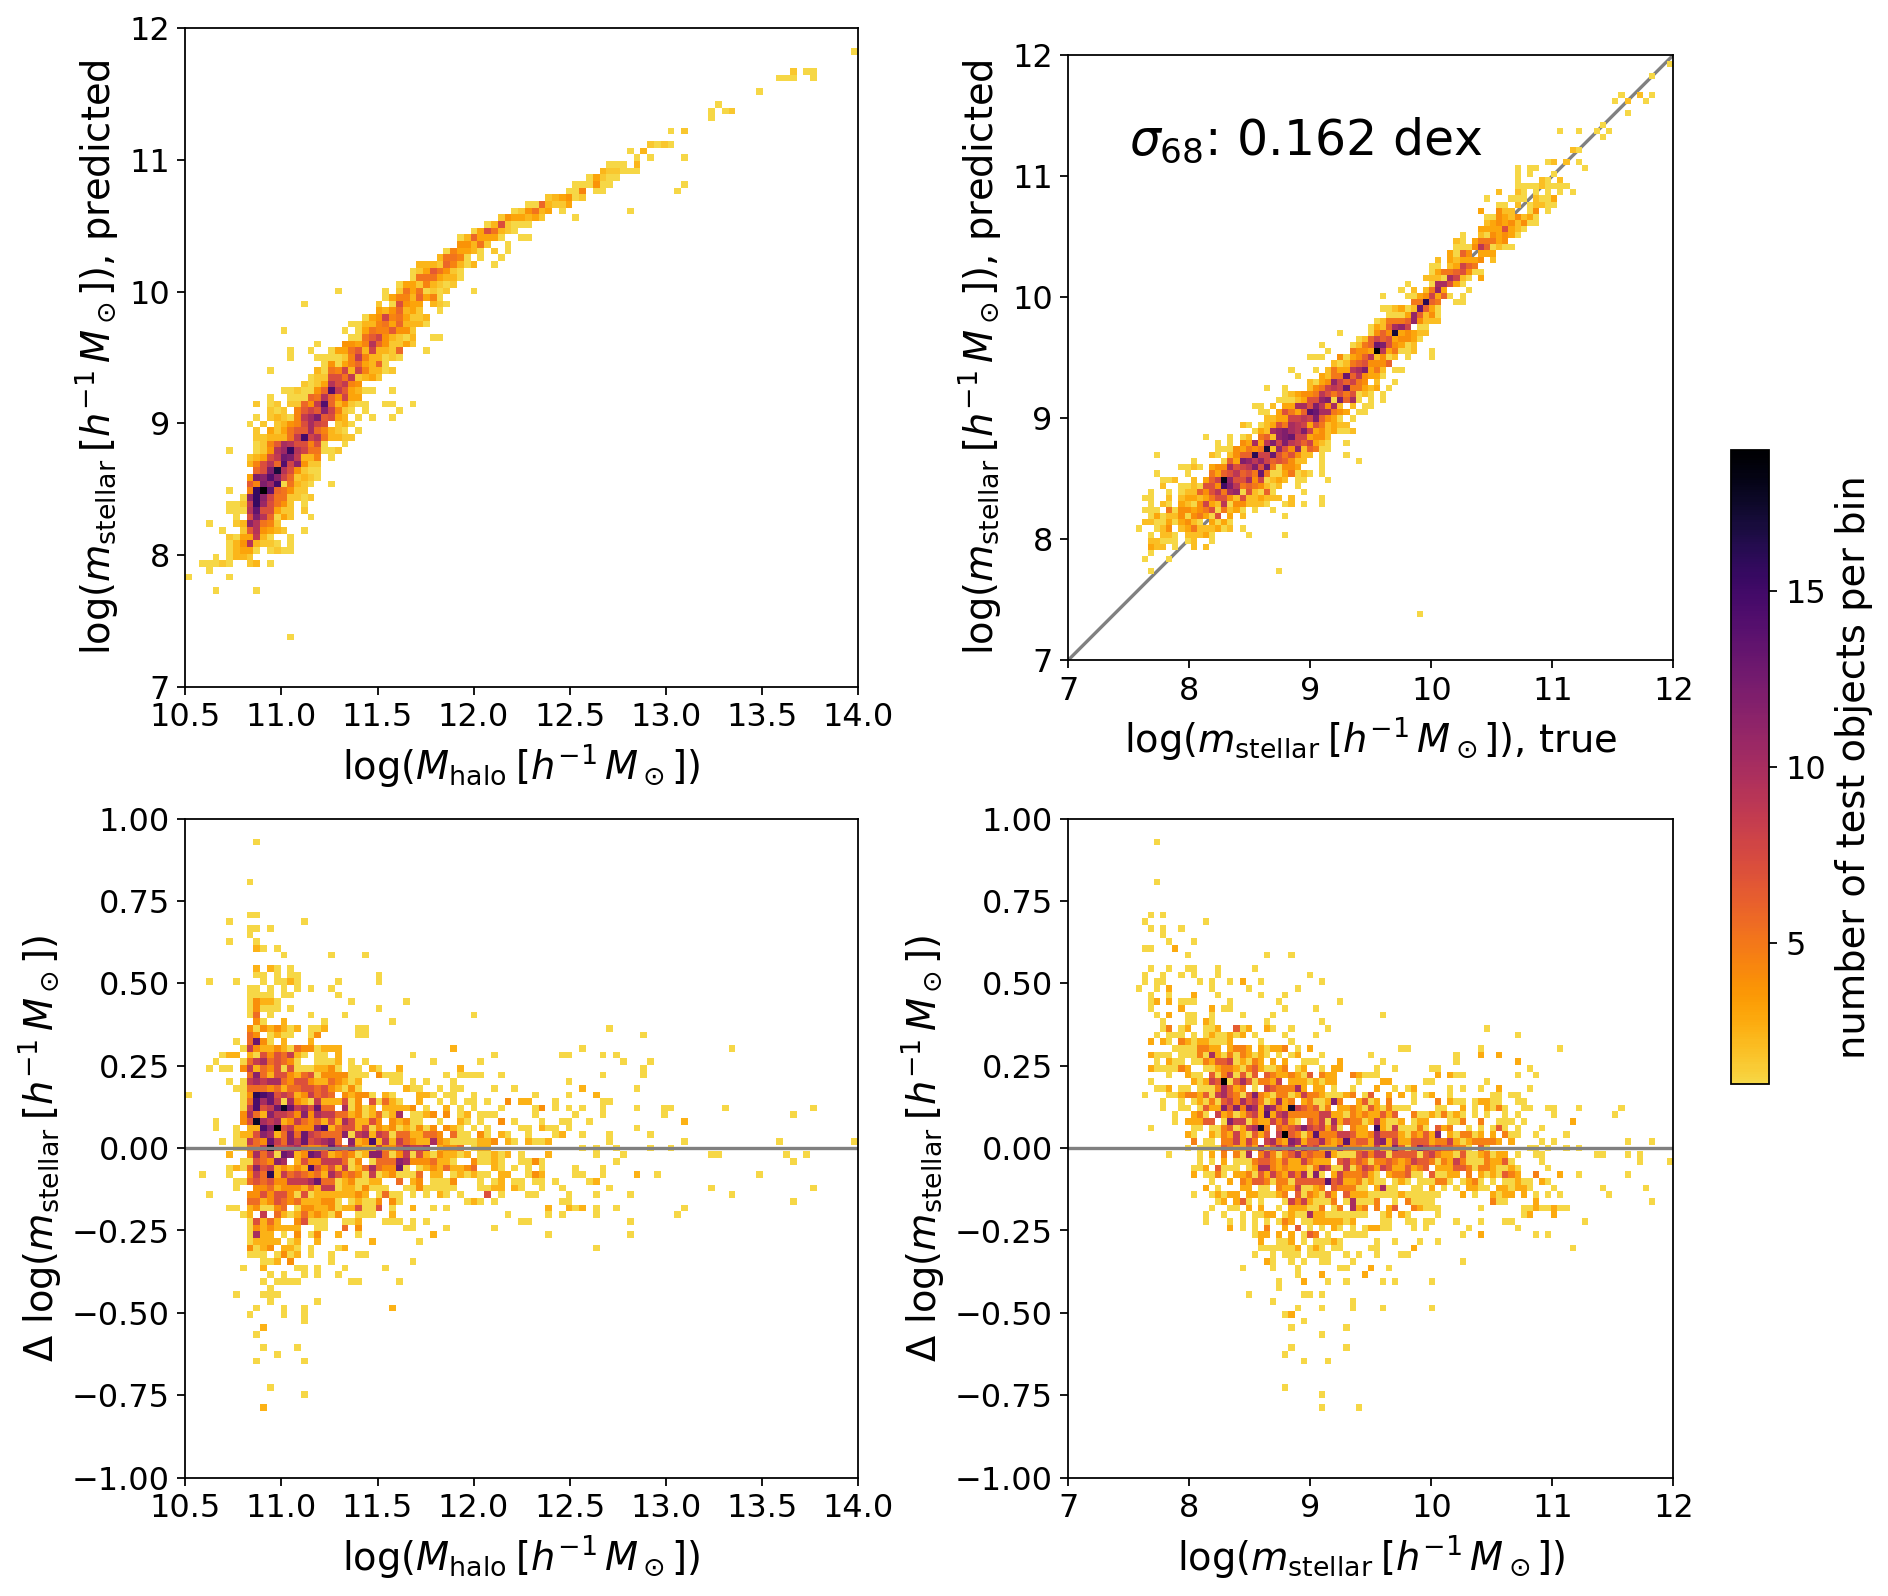

In [57]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test_mult, y_pred_mult, 
                              text_results=error_str)

NameError: name 'plot_errors_vs_property' is not defined

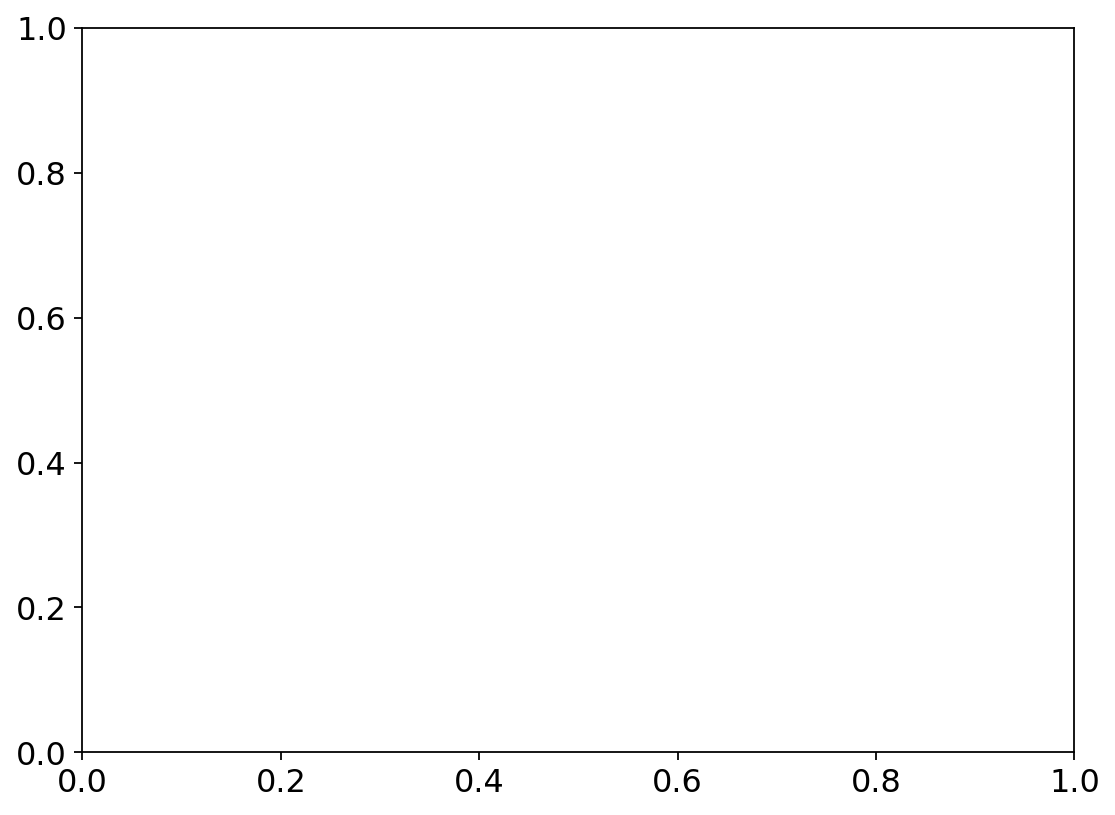

In [58]:
plt.figure(figsize=(8,6))
ax = plt.gca()
x_property = log_m_200m[idx_test] + log_mass_shift
plot_errors_vs_property(ax, x_label_name, y_label_name, x_property, y_test_mult, y_pred_arr, 
                       feature_names)

# Multi mstellar

In [59]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
y_label_name_arr = ['m_stellar', 'ssfr1', 'r_stellar', 'gband_minus_iband', 'bhmass_per_mstellar', 'j_stellar']
y_label_name_train = '_'.join(y_label_name_arr)
fit_tag = f'_{y_label_name_train}_nn_scalars_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.npy'

In [60]:
y_pred_train = np.load(fn_pred)
print(y_pred_train.shape)

(2951, 6)


In [61]:
y_pred = y_pred_train[:,0]

In [62]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:360: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


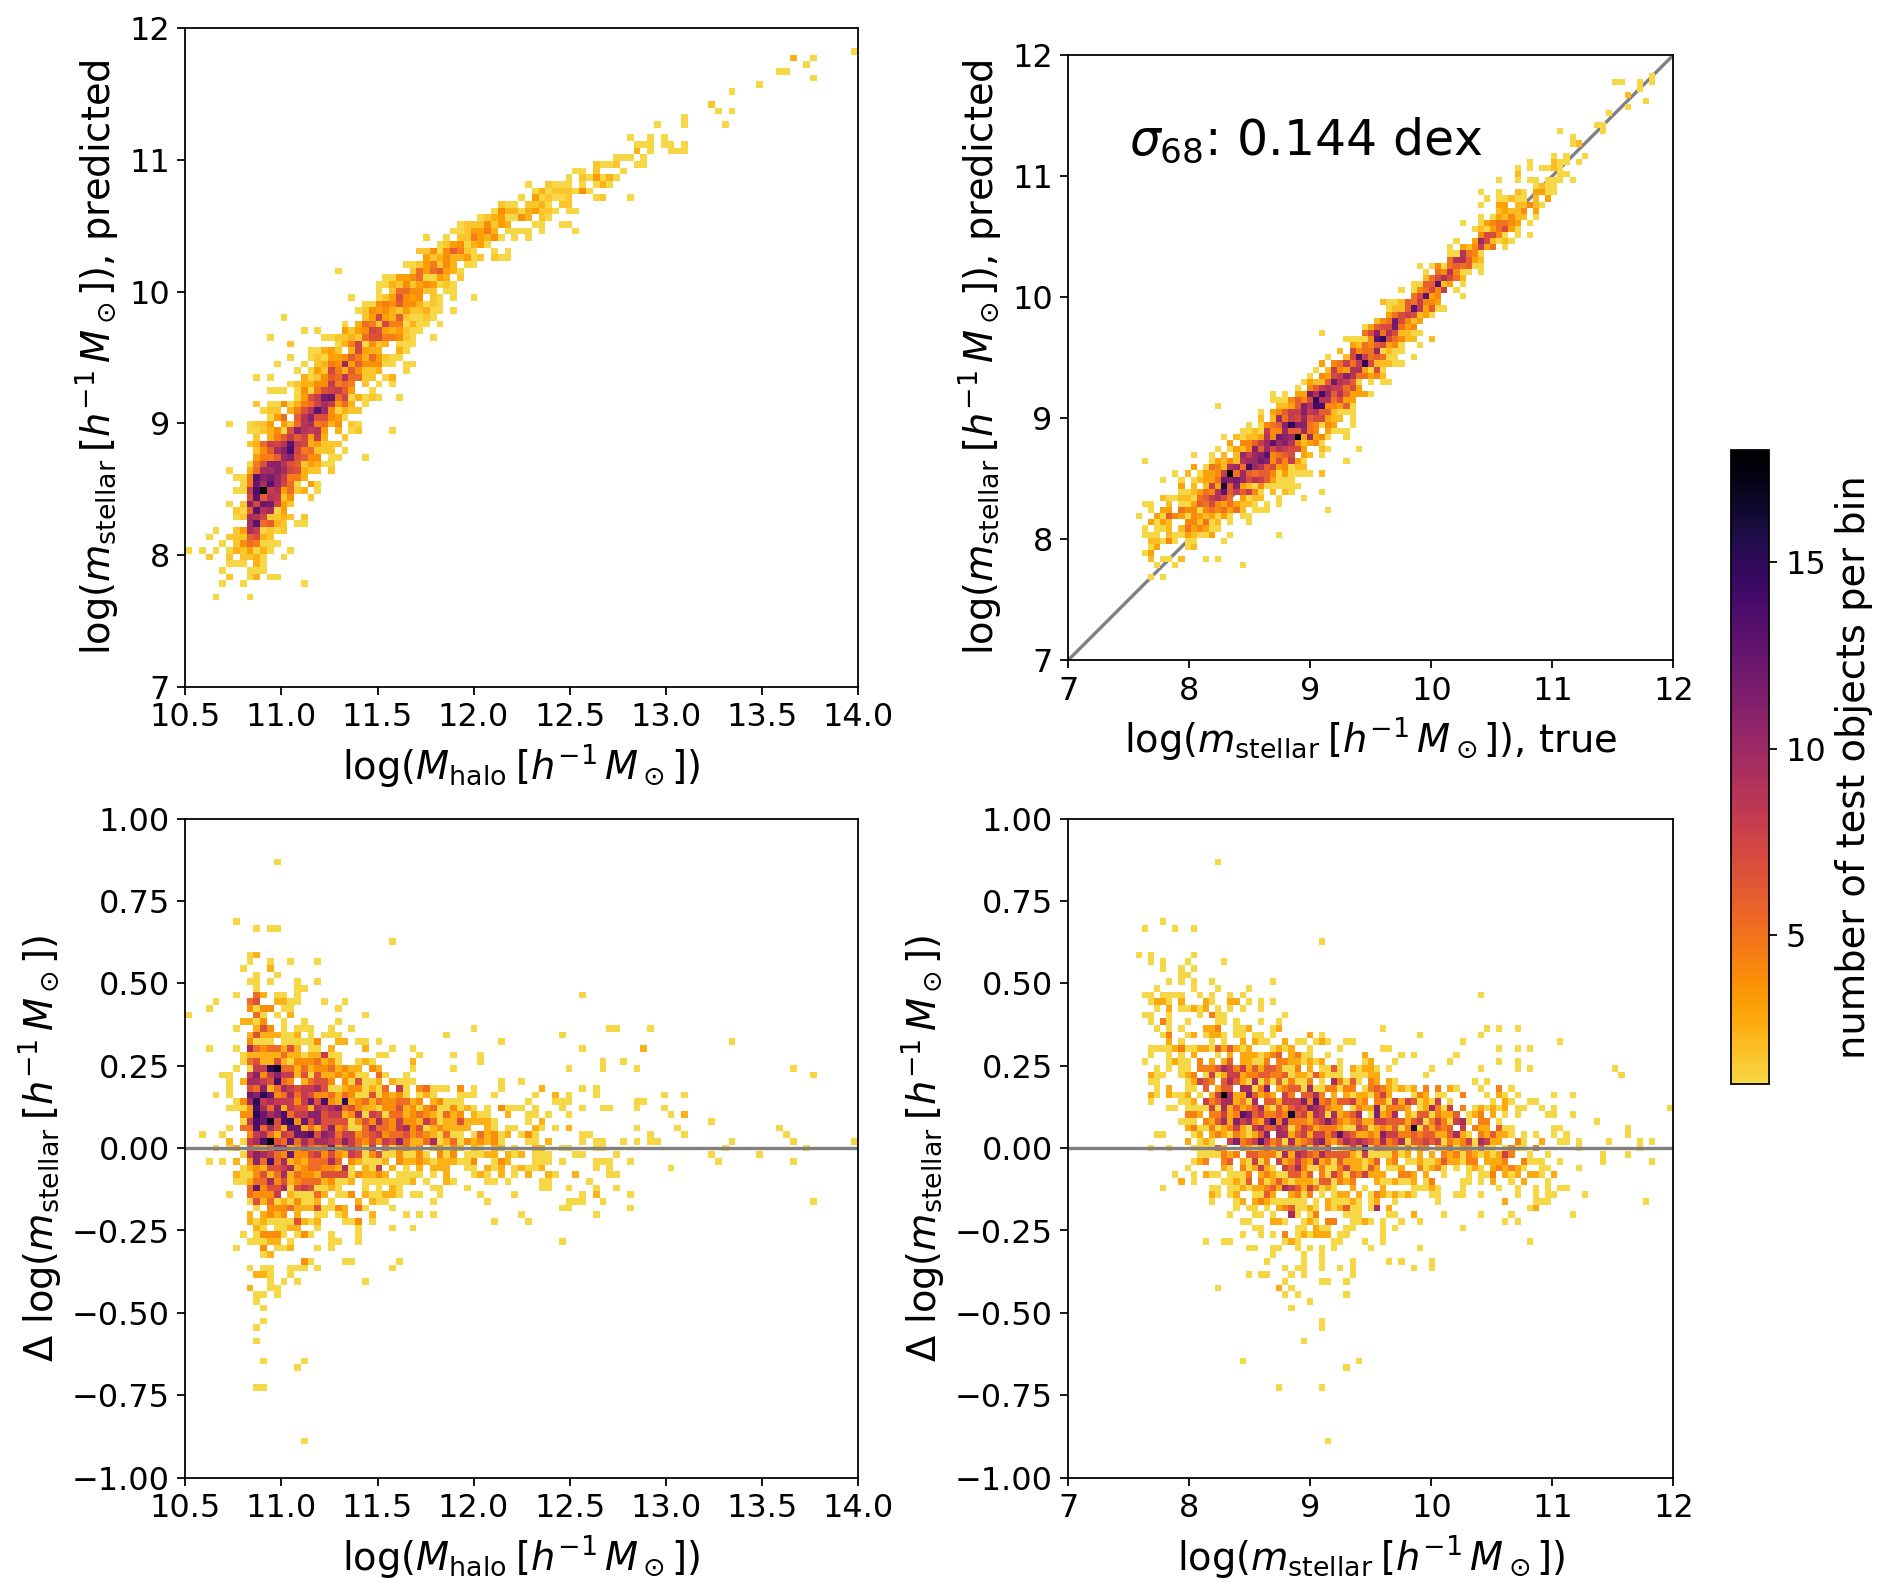

In [63]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test_mult, y_pred_mult, 
                              text_results=error_str)

## Butterfly limit m_stellar

In [17]:
# columns:  Mh1    , Ms1,   , Mh2    , Ms2
arr_butterfly = np.loadtxt('../data/butterfly_m_stellar_TNG100-1.csv', skiprows=1, 
                                delimiter=',')
print(arr_butterfly.shape)

(731, 4)


In [18]:
# should get from halo_params, but had typo in fiducial; update when redo
halo_logmass_min = 10.8
mh1, mh2 = arr_butterfly[:,0], arr_butterfly[:,2]
i_masscut = (mh1 >= halo_logmass_min) & (mh2 >= halo_logmass_min)
print(np.sum(i_masscut))
arr_butterfly = arr_butterfly[i_masscut]
mh1, ms1, mh2, ms2 = arr_butterfly.T

554


In [24]:
# diffs should not be absvalled here right?
diffs = ms1 - ms2
stdev_pairwise = np.std(diffs)
print(stdev_pairwise)
stdev_pairwise /= np.sqrt(2) #see sec 2.2.2 of butterfly paper for explanation
print(stdev_pairwise)

0.09943994337461015
0.07031465828099313


In [46]:
# can't figure out hpw these bins are defined - taking mean of the two for now 
#(tho this is diff than asking both of them to be greater, as did for cut)
mh_mean = np.log10(0.5*(10**mh1+10**mh2))
mh_bins = np.linspace(halo_logmass_min, np.max(mh_mean) + 0.01, 10)
stdevs_mh = []
for i in range(len(mh_bins)-1):
    i_inbin = (mh_mean >= mh_bins[i]) & (mh_mean < mh_bins[i+1])
    ms1_inbin, ms2_inbin = ms1[i_inbin], ms2[i_inbin]
    stdev_pairwise = np.std(ms1_inbin - ms2_inbin) / np.sqrt(2)
    stdevs_mh.append(stdev_pairwise)

Text(0, 0.5, 'stdev of pairwise diffs / $\\sqrt{2}$')

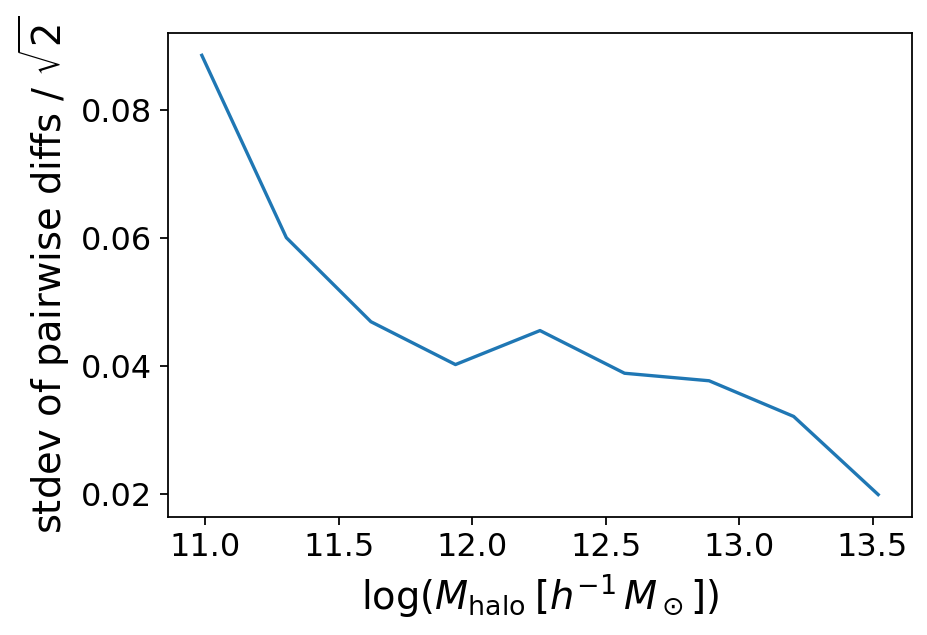

In [47]:
mh_bins_avg = np.log10(0.5*(10**mh_bins[:-1] + 10**mh_bins[1:]))
plt.plot(mh_bins_avg, stdevs_mh)
plt.xlabel(utils.get_label('m_200m'))
plt.ylabel(r'stdev of pairwise diffs / $\sqrt{2}$')

In [48]:
# can't figure out hpw these bins are defined - taking mean of the two for now 
#(tho this is diff than asking both of them to be greater, as did for cut)
ms_mean = np.log10(0.5*(10**ms1+10**ms2))
ms_bins = np.linspace(np.min(ms_mean), np.max(ms_mean) + 0.01, 10)
stdevs_ms = []
for i in range(len(mh_bins)-1):
    i_inbin = (mh_mean >= mh_bins[i]) & (mh_mean < mh_bins[i+1])
    ms1_inbin, ms2_inbin = ms1[i_inbin], ms2[i_inbin]
    stdev_pairwise = np.std(ms1_inbin - ms2_inbin) / np.sqrt(2)
    stdevs_ms.append(stdev_pairwise)

Text(0, 0.5, 'stdev of pairwise diffs / $\\sqrt{2}$')

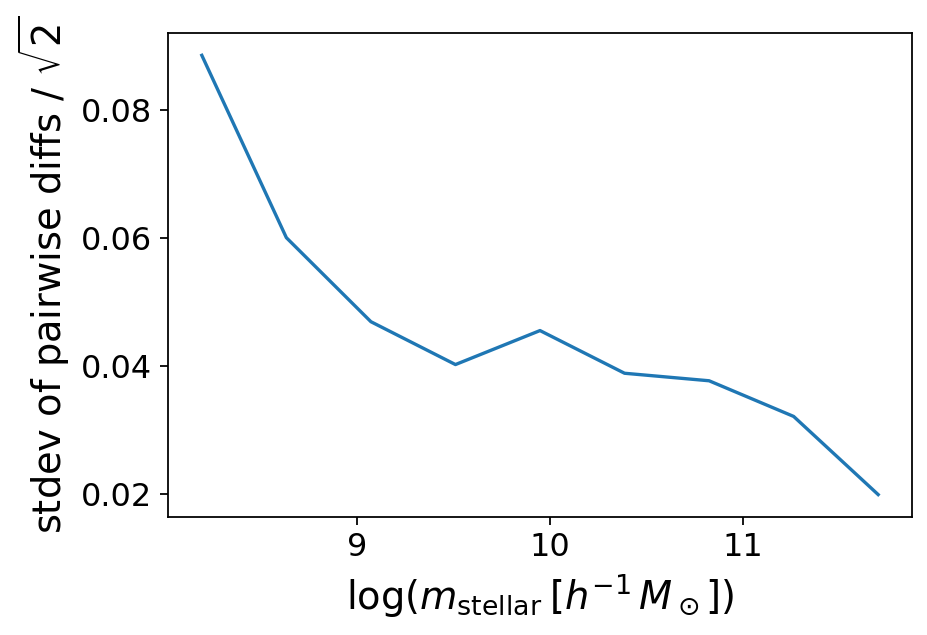

In [49]:
ms_bins_avg = np.log10(0.5*(10**ms_bins[:-1] + 10**ms_bins[1:]))
plt.plot(ms_bins_avg, stdevs_mh)
plt.xlabel(utils.get_label('m_stellar'))
plt.ylabel(r'stdev of pairwise diffs / $\sqrt{2}$')

## Multi all

In [93]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']

In [94]:
feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
print(feature_labels)

['Invariant scalar features', 'Geometric features', 'Standard halo features', 'M200, R200, V200']


In [95]:
y_pred_arr = []
text_results_arr = []
for i, feature_mode in enumerate(feature_modes):
    fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    if feature_mode=='scalars':
        fit_tag = '_elementary'+fit_tag
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

    y_pred = np.load(fn_pred)
    y_pred_mult = y_pred + log_mass_shift
    y_pred_arr.append(y_pred_mult)
    
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    text_results_arr.append(error_str)

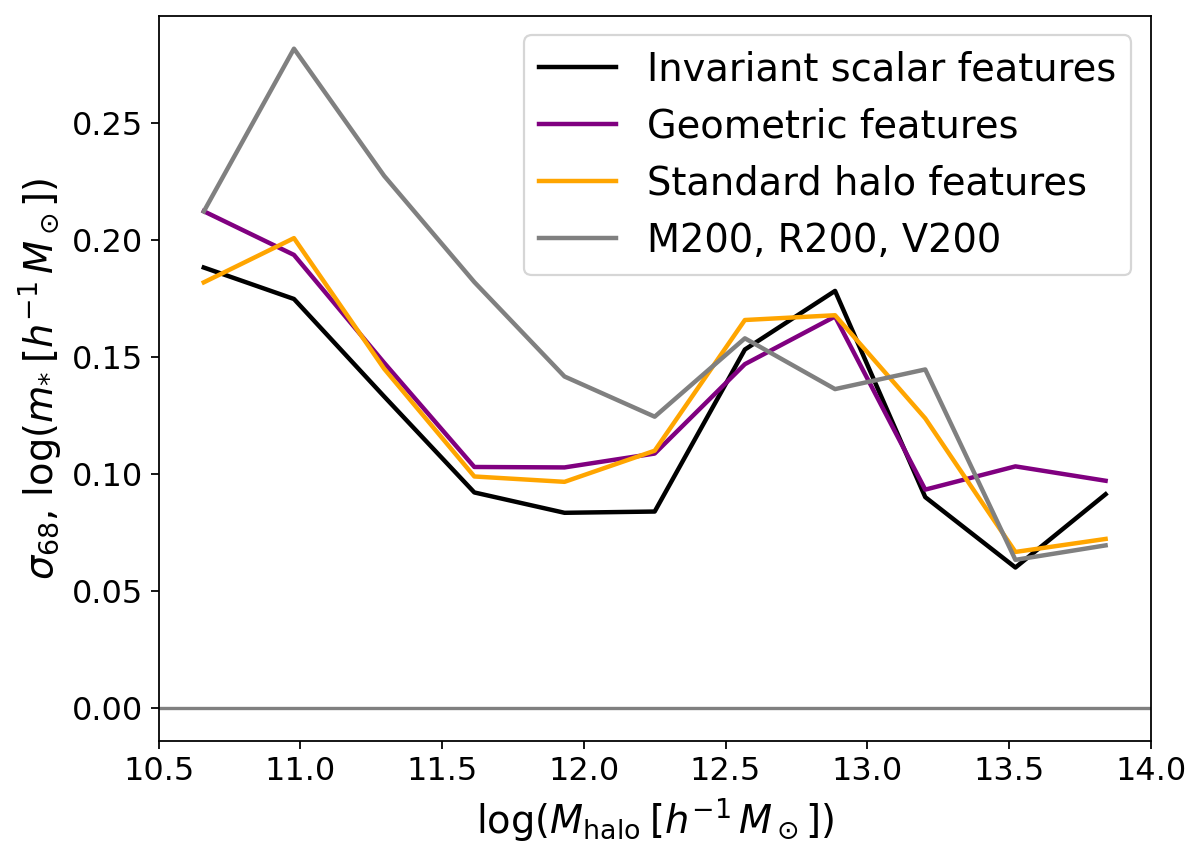

In [96]:
#colors = ['black', 'purple', 'orange']
colors = ['black', 'purple', 'orange', 'grey']

plt.figure(figsize=(8,6))
ax = plt.gca()
x_property = log_m_200m[idx_test] + log_mass_shift
plotter.plot_errors_vs_property(ax, x_label_name, y_label_name, x_property, y_test_mult, y_pred_arr, 
                       feature_labels, colors)

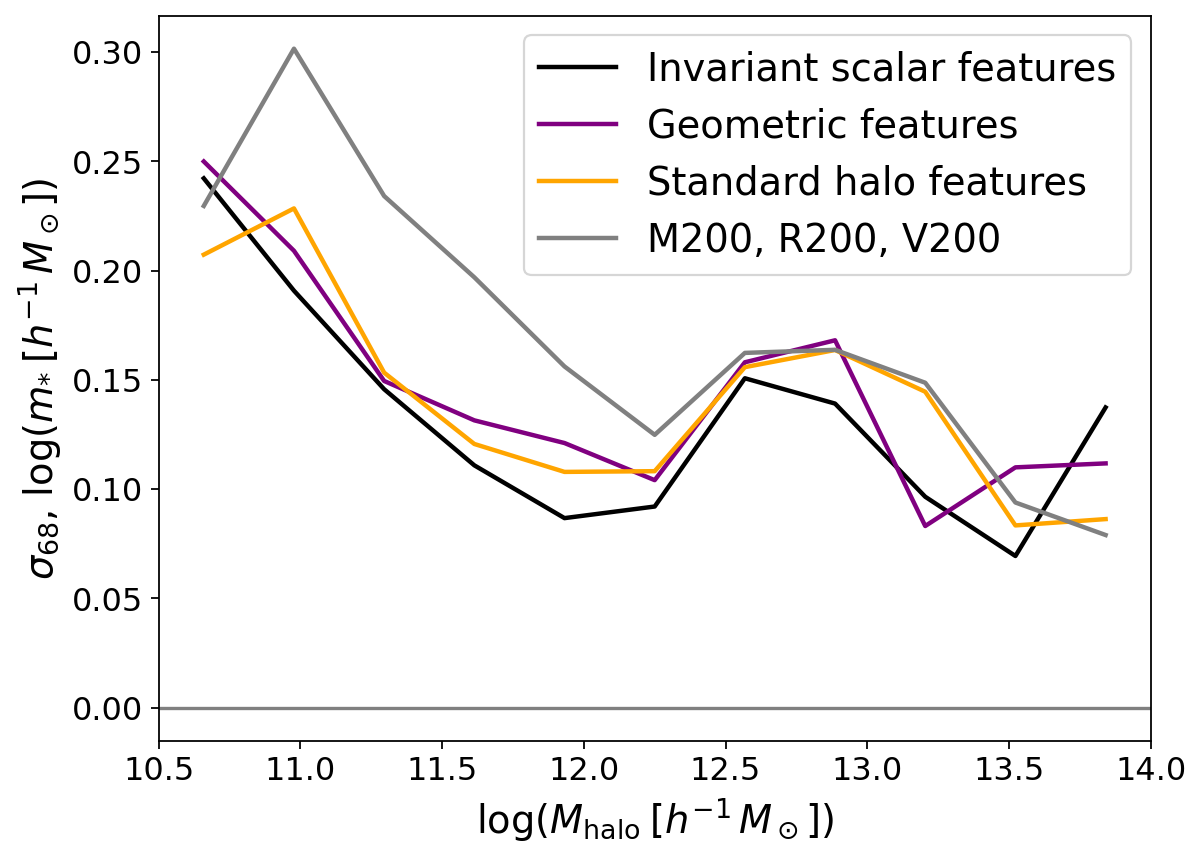

In [97]:
#colors = ['black', 'purple', 'orange']
colors = ['black', 'purple', 'orange', 'grey']

plt.figure(figsize=(8,6))
ax = plt.gca()
x_property = log_m_200m[idx_test] + log_mass_shift
plotter.plot_errors_vs_property(ax, x_label_name, y_label_name, x_property, y_test_mult, y_pred_arr, 
                       feature_labels, colors, test_error_type='stdev')

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:360: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


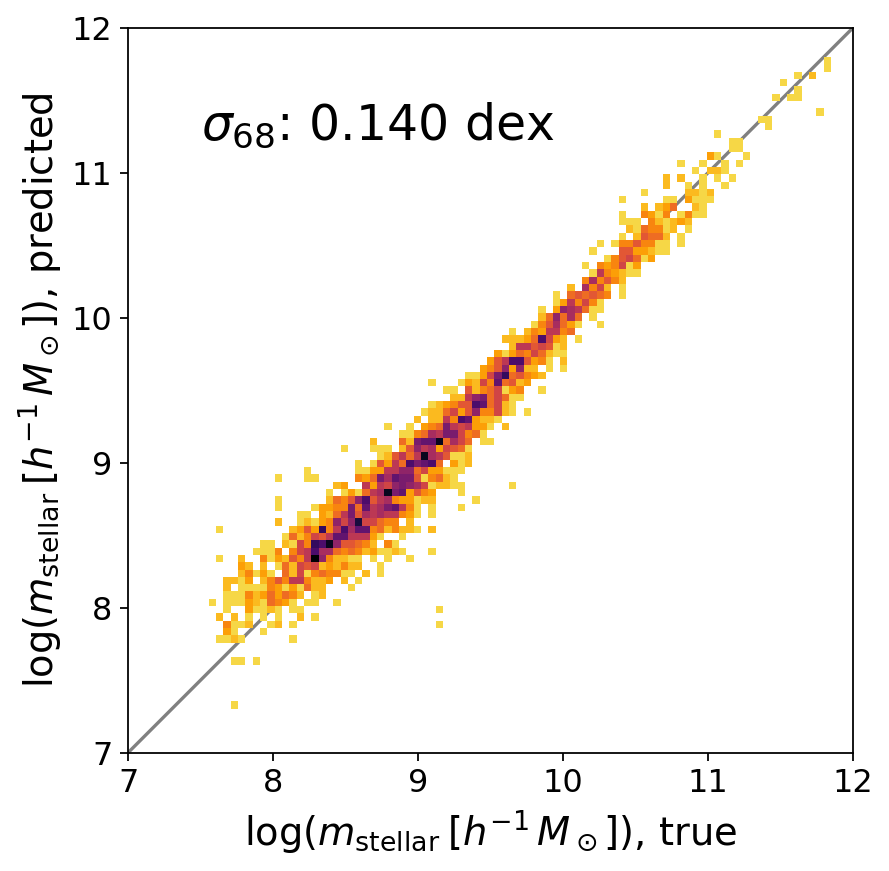

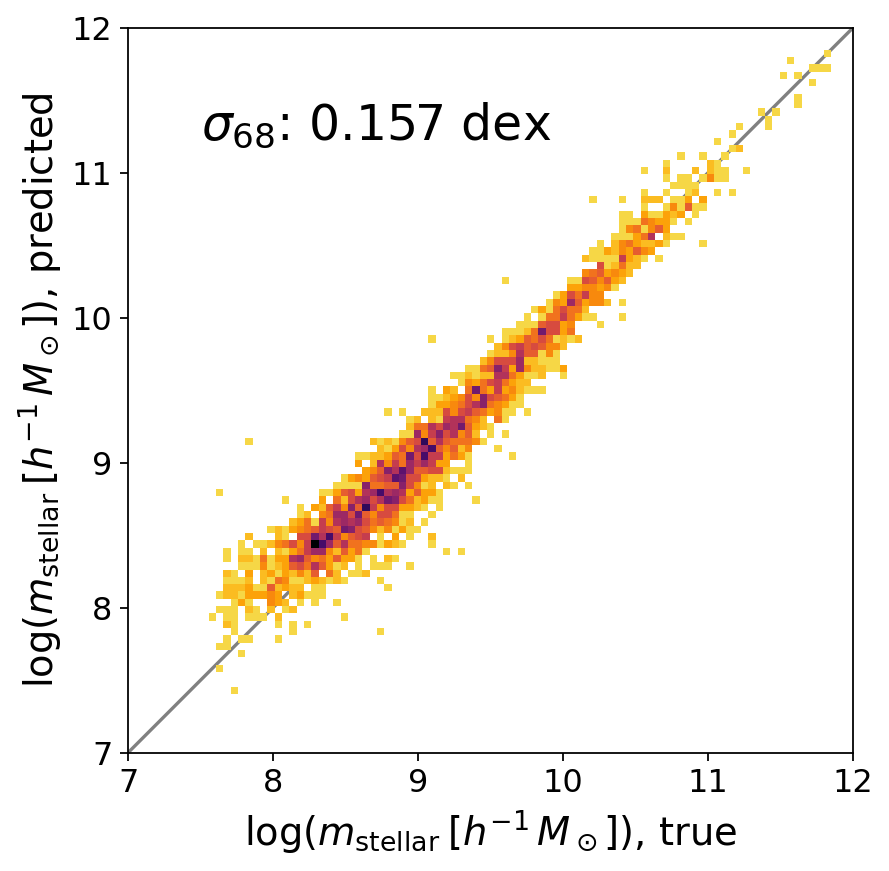

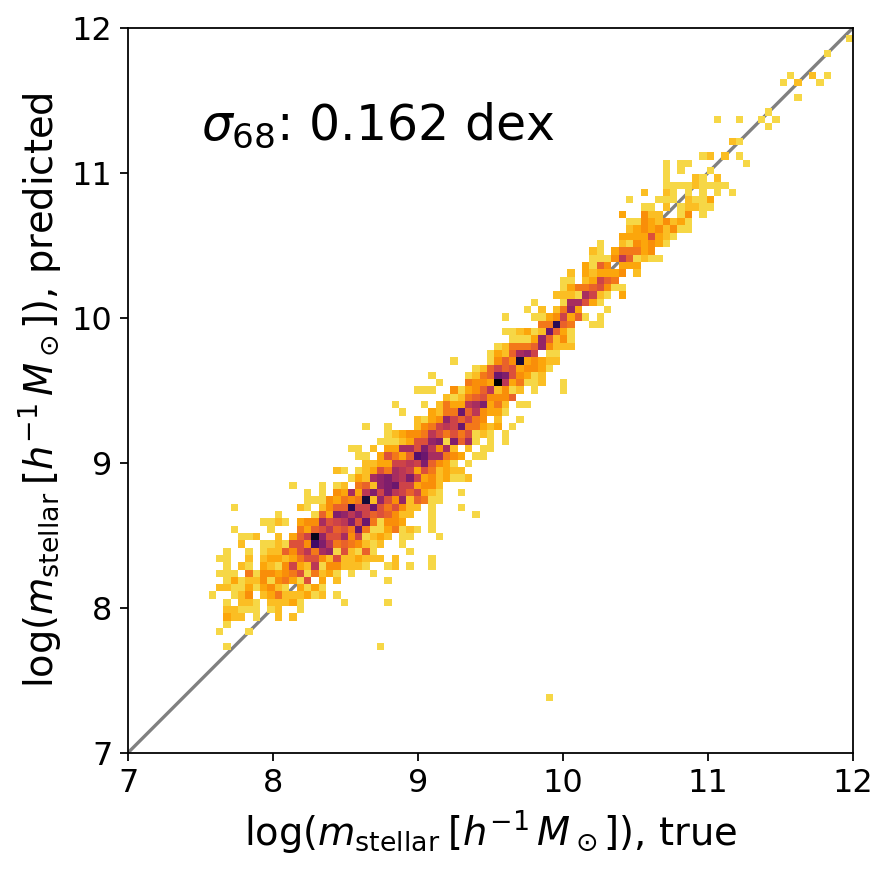

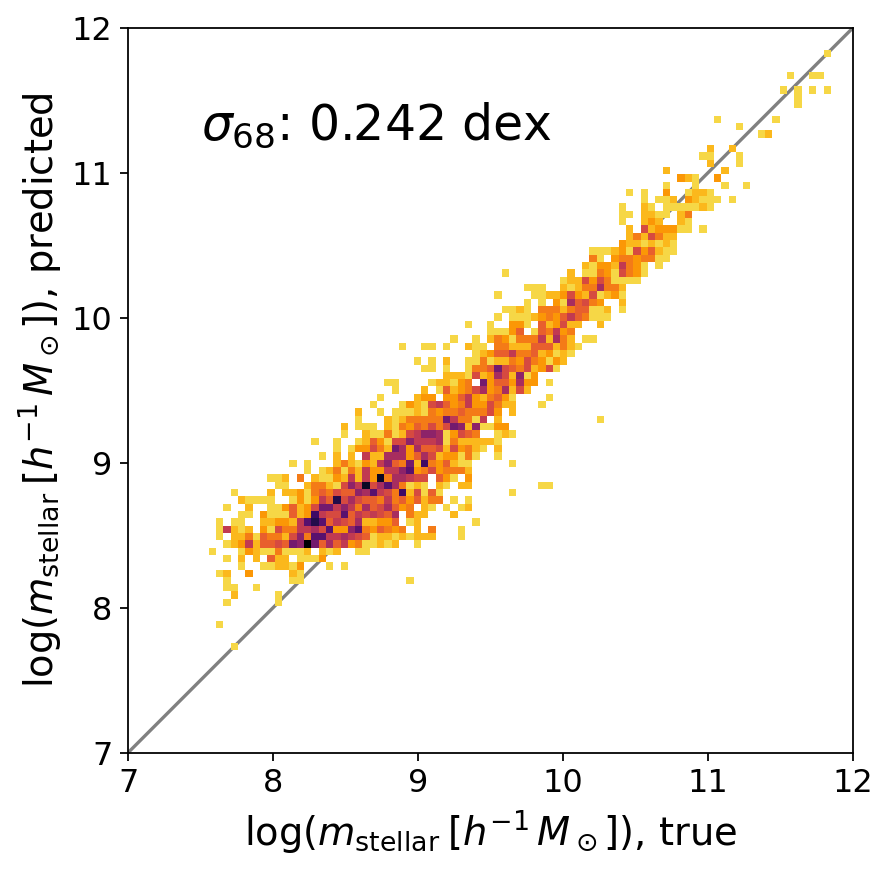

In [136]:

inferno_r = matplotlib.cm.inferno_r
cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
for i in range(len(y_pred_arr)):
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    y_pred = y_pred_arr[i]
    plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred, cmap, text_results=text_results_arr[i])

In [121]:
len(idx_test), len(sim_reader.dark_halo_arr)

(2951, 19670)

In [126]:
sim_reader.box_size

75000.0

In [136]:
frac_test = len(idx_test)/len(sim_reader.dark_halo_arr)
L_Mpc = sim_reader.box_size / 1000.0
weight = 1/(L_Mpc**3 * frac_test)
colorbar_label = r'$\bar{n}$ per dex [1/(($h^{-1}$ Mpc)$^3$ dex)]'

1.5799791658822497e-05


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  def log_sfr_to_log_ssfr(log_sfr_arr, m_stellar_arr, mass_multiplier=1e10):


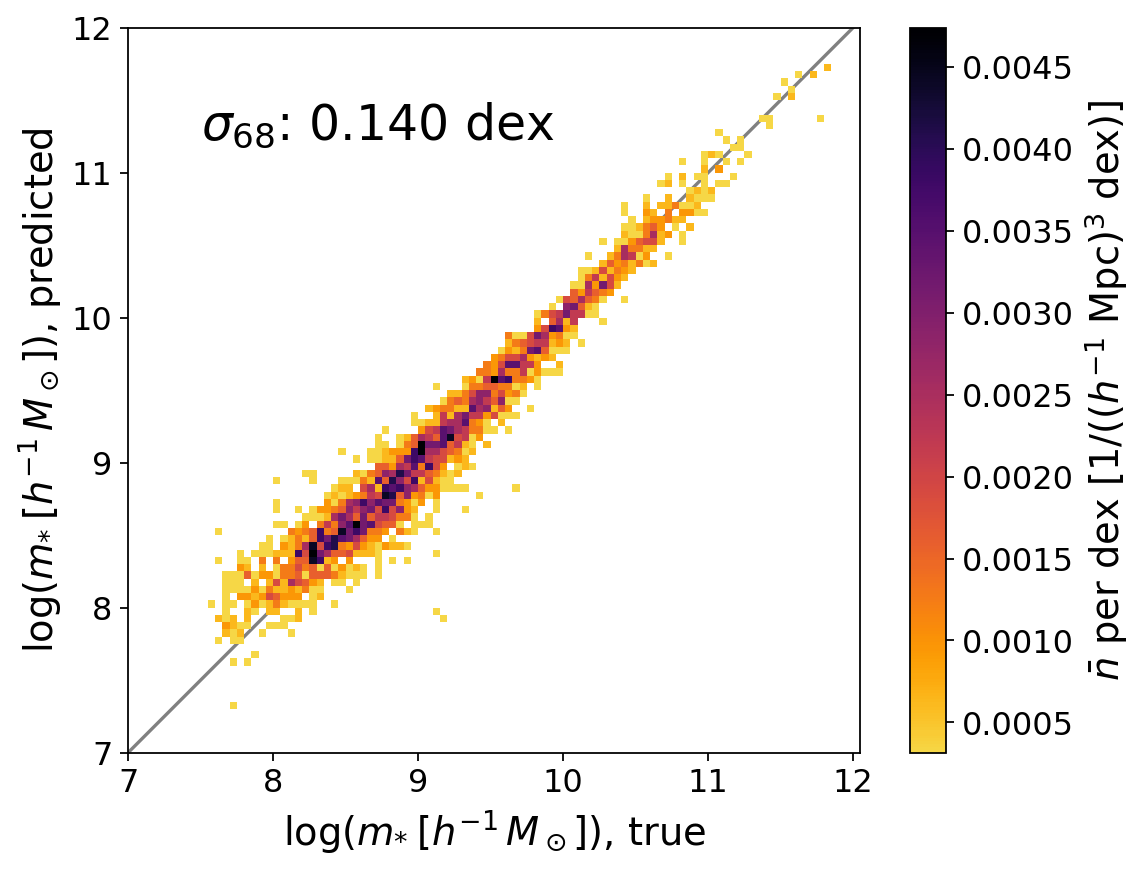

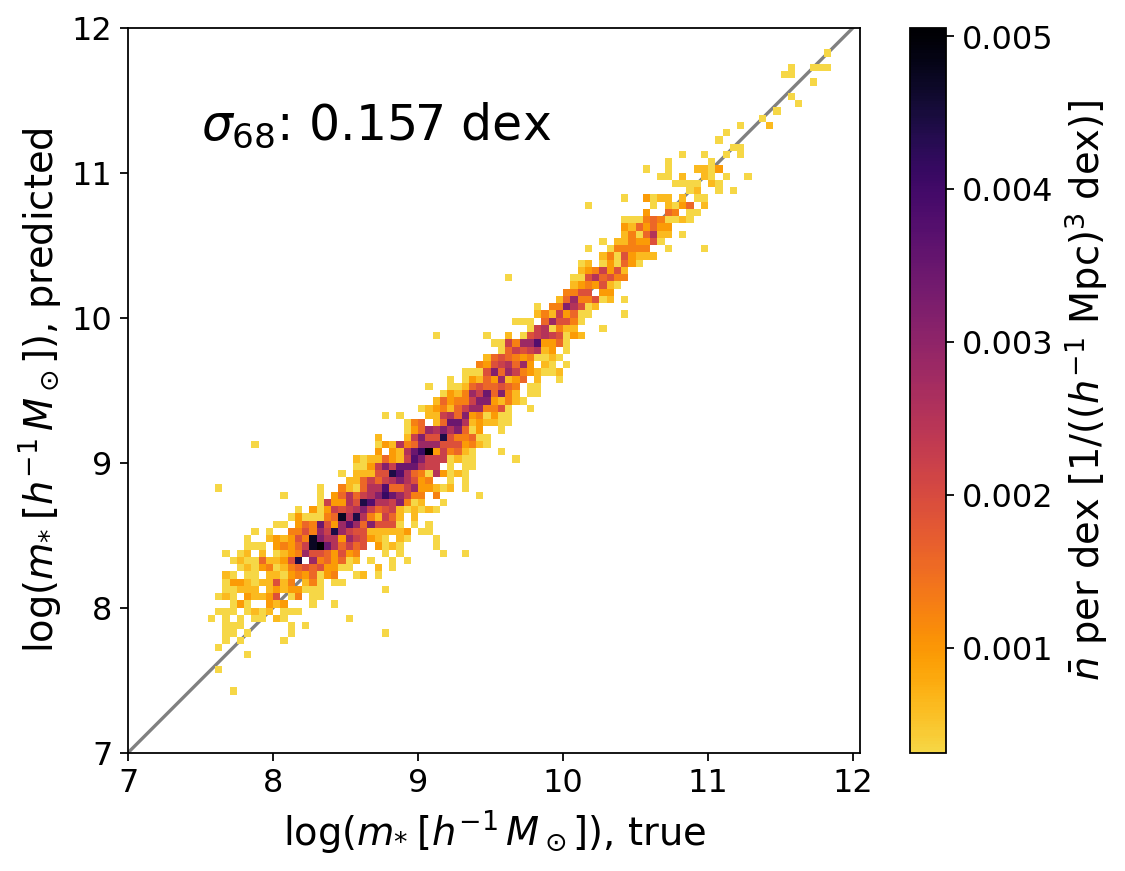

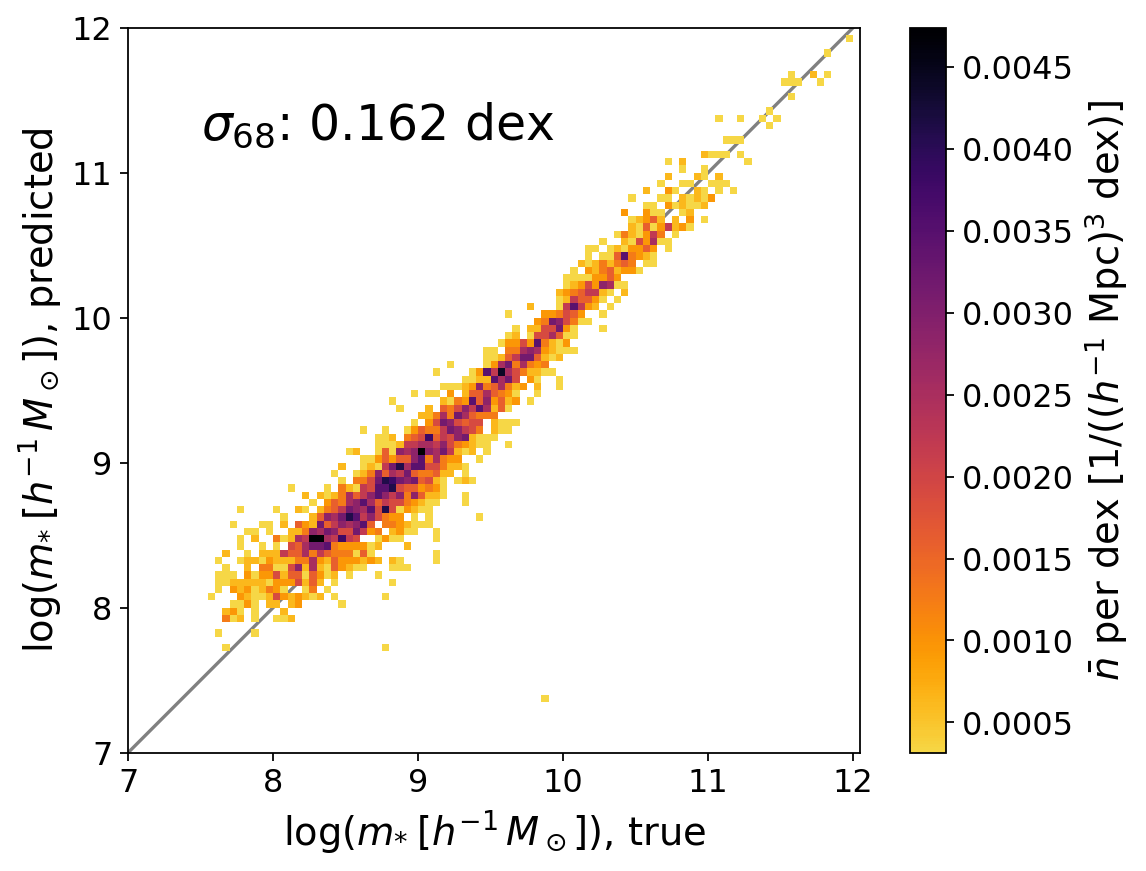

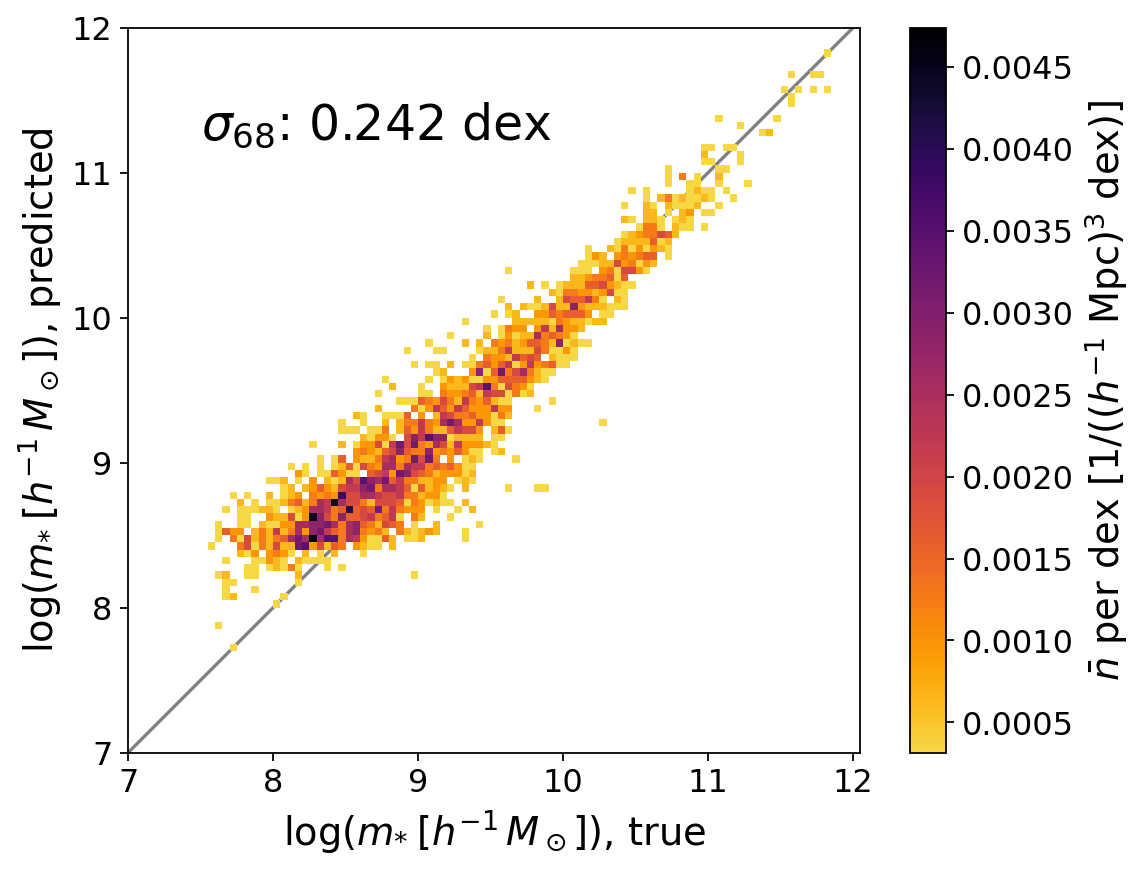

In [137]:
inferno_r = matplotlib.cm.inferno_r
cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
for i in range(len(y_pred_arr)):
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    fig = plt.gcf()
    y_pred = y_pred_arr[i]
    plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred, cmap, text_results=text_results_arr[i],
                                  colorbar_fig=fig, weight=weight, weight_by_dex=True, colorbar_label=colorbar_label)

In [101]:
# plotter.plot_multi_panel_gal_props(x_label_name, y_label_name_arr, x_property, y_test, y_pred_arr,
#                       text_results_arr='text_results_arr')

# a_mfrac

In [14]:
y_label_name = 'a_mfrac_n39'
feature_mode = 'scalars'
fit_tag = f'_elementary_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [16]:
y_pred = np.load(fn_pred)
print(y_pred.shape)

(2951, 39)


In [17]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [18]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does

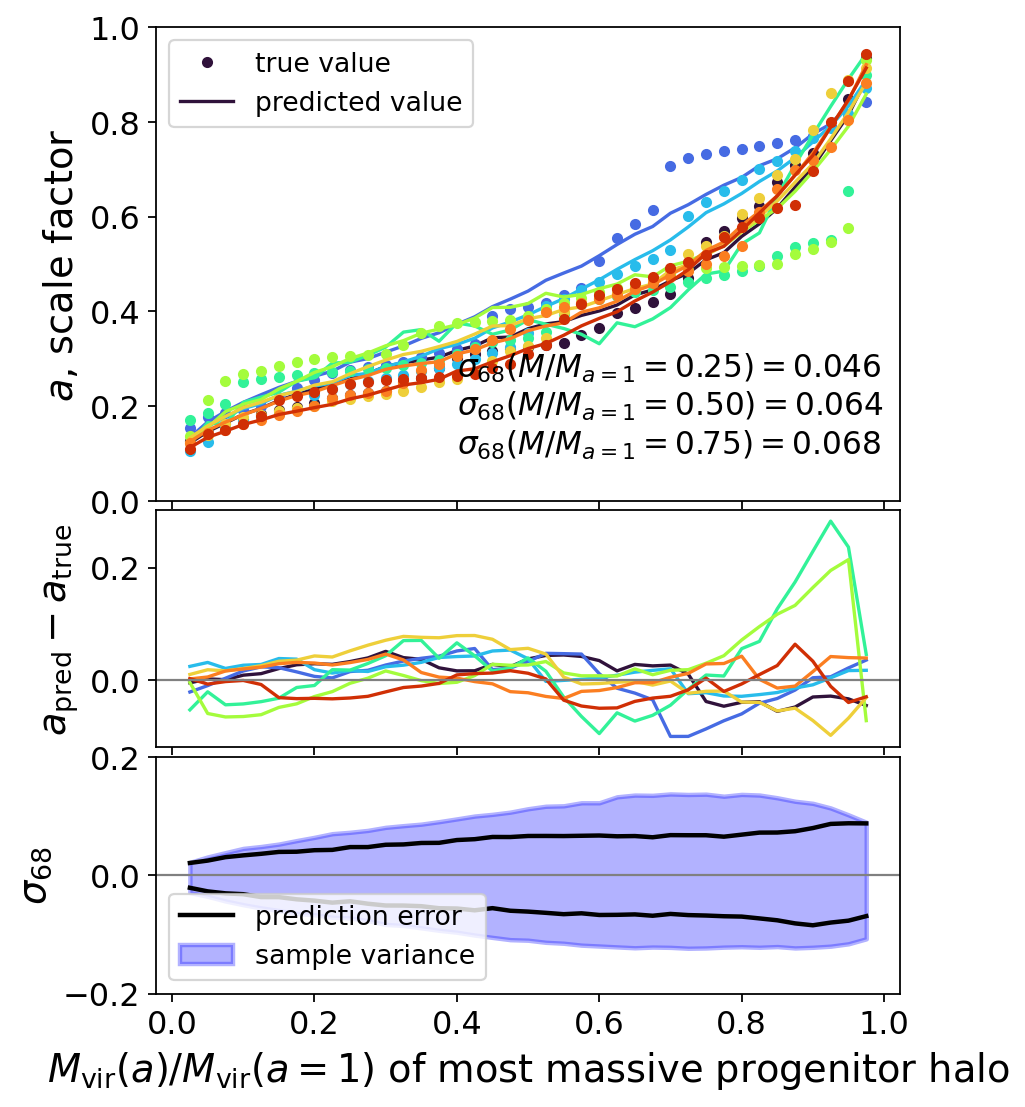

In [24]:
plotter.plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

In [27]:
y_label_name = 'a_mfrac_n39'
feature_mode = 'catalog_z0'
fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [28]:
y_pred = np.load(fn_pred)
print(y_pred.shape)

(2951, 39)


In [29]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [30]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does

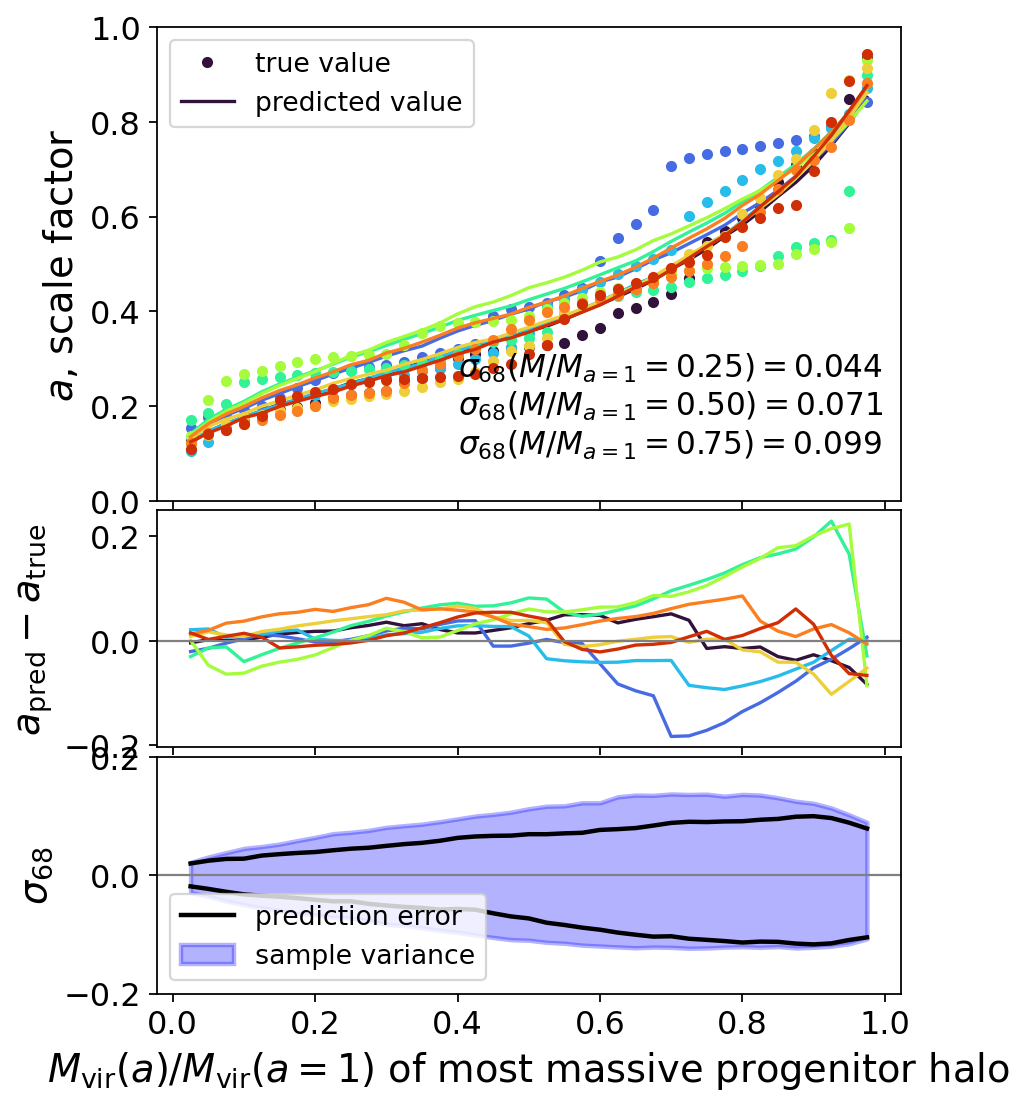

In [31]:
plotter.plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

In [32]:
y_label_name = 'a_mfrac_n39'
feature_mode = 'geos'
fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [33]:
y_pred = np.load(fn_pred)
print(y_pred.shape)

(2951, 39)


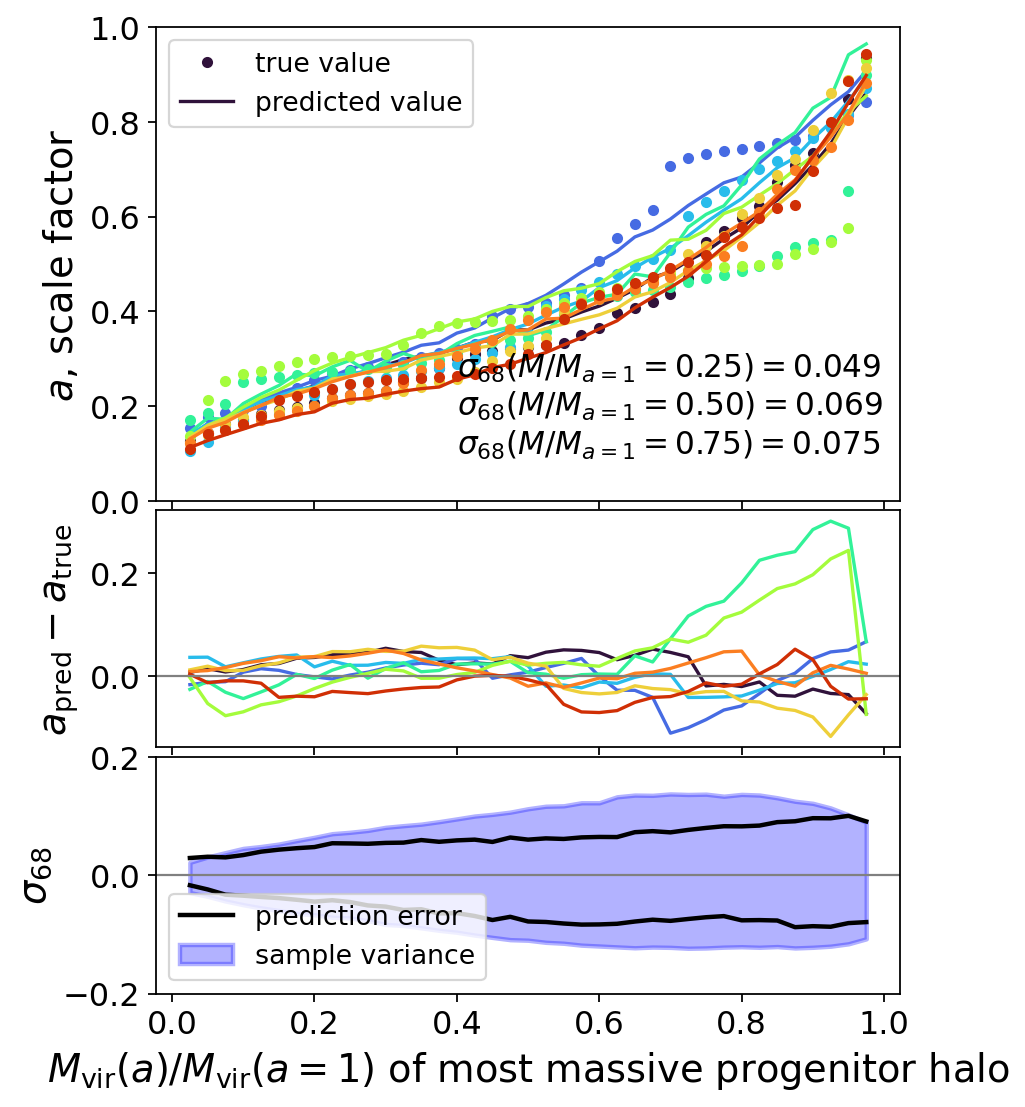

In [34]:
plotter.plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

# Function of Mhalo

In [150]:
y_label_name = 'a_mfrac_n39'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
feature_modes = ['mrv', 'catalog_z0', 'geos', 'scalars']
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does

In [152]:
feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
colors = ['grey', 'orange', 'purple', 'black']
lws = [1.5, 1.5, 1.5, 2.5]

In [153]:
mfrac_target = 0.8
_, idx_mfrac = utils.find_nearest(mfrac_vals, mfrac_target)
y_test_mtarget = y_test[:,idx_mfrac]
y_test_mavg = np.mean(y_test, axis=1)
print(y_test_mavg.shape)

(2951,)


In [154]:
y_pred_mtarget_arr = []
y_pred_mavg_arr = []
y_pred_arr = []
for i, feature_mode in enumerate(feature_modes):
    fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    if feature_mode=='scalars':
        fit_tag = '_elementary'+fit_tag
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

    y_pred = np.load(fn_pred)
    y_pred_arr.append(y_pred)
    y_pred_mtarget_arr.append(y_pred[:,idx_mfrac])    
    y_pred_mavg_arr.append(np.mean(y_pred, axis=1))

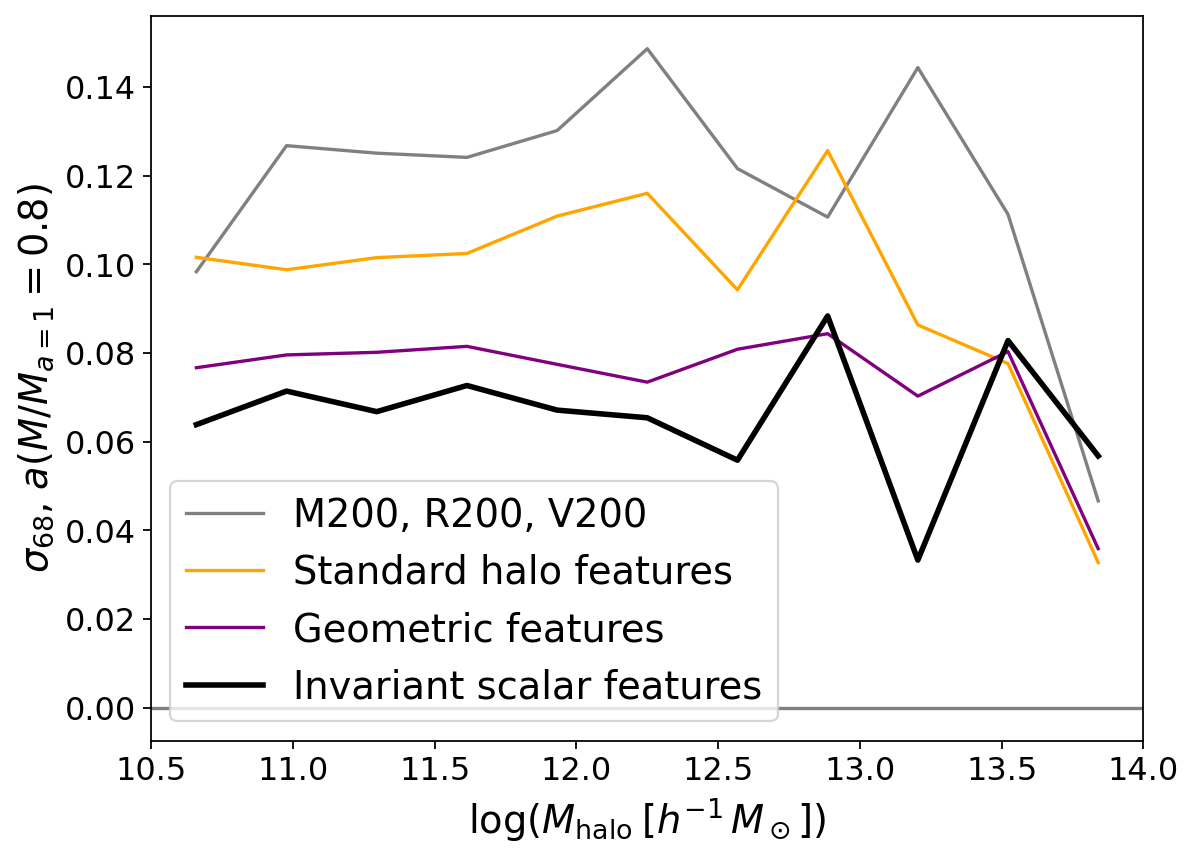

In [155]:
x_label_name = 'm_200m'
x_property = log_m_200m[idx_test] + log_mass_shift
y_label_name_mfrac = rf'$a(M/M_{{a=1}}={mfrac_target})$'
#colors = ['black', 'purple', 'orange']

plt.figure(figsize=(8,6))
ax = plt.gca()

plotter.plot_errors_vs_property(ax, x_label_name, y_label_name_mfrac, x_property, y_test_mtarget, y_pred_mtarget_arr, 
                       feature_labels, colors, lws=lws)

In [156]:
mfrac_target = 0.6
_, idx_mfrac = utils.find_nearest(mfrac_vals, mfrac_target)
y_test_mtarget = y_test[:,idx_mfrac]
y_test_mavg = np.mean(y_test, axis=1)
print(y_test_mavg.shape)

(2951,)


In [157]:
y_pred_mtarget_arr = []
y_pred_mavg_arr = []
y_pred_arr = []
for i, feature_mode in enumerate(feature_modes):
    fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    if feature_mode=='scalars':
        fit_tag = '_elementary'+fit_tag
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

    y_pred = np.load(fn_pred)
    y_pred_arr.append(y_pred)
    y_pred_mtarget_arr.append(y_pred[:,idx_mfrac])    
    y_pred_mavg_arr.append(np.mean(y_pred, axis=1))

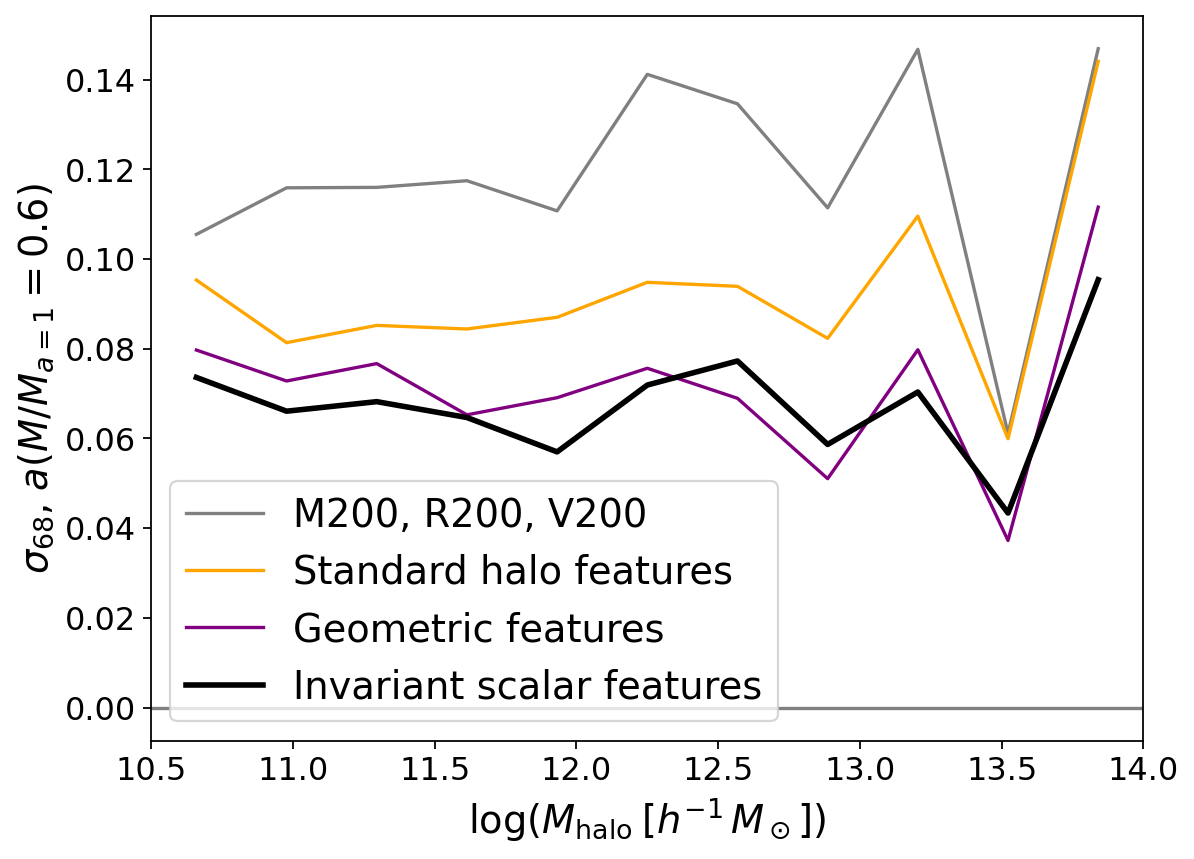

In [158]:
x_label_name = 'm_200m'
x_property = log_m_200m[idx_test] + log_mass_shift
y_label_name_mfrac = rf'$a(M/M_{{a=1}}={mfrac_target})$'

plt.figure(figsize=(8,6))
ax = plt.gca()

plotter.plot_errors_vs_property(ax, x_label_name, y_label_name_mfrac, x_property, y_test_mtarget, y_pred_mtarget_arr, 
                       feature_labels, colors, lws=lws)

For this i'm flattening the a's over all the mfracs; does this make sense??

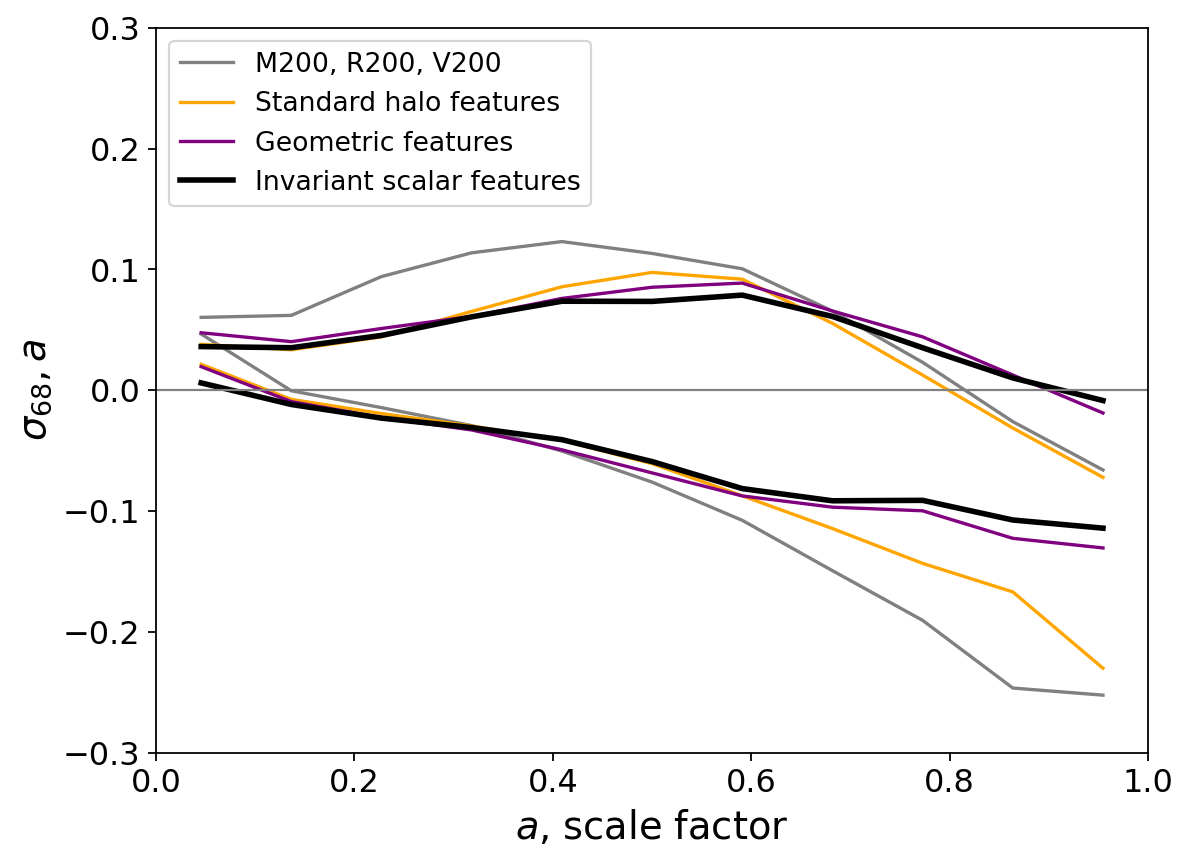

In [190]:
plt.figure(figsize=(8,6))
ax = plt.gca()
plotter.plot_errors_vs_a(ax, y_pred_arr, y_test, feature_labels, colors, 
                              lws=lws, legend_loc='upper left')

Currently plotting 1/5 the data bc of the negatives & >1s issue! (see below)

FOR TESTING
conv true
conv pred
done!


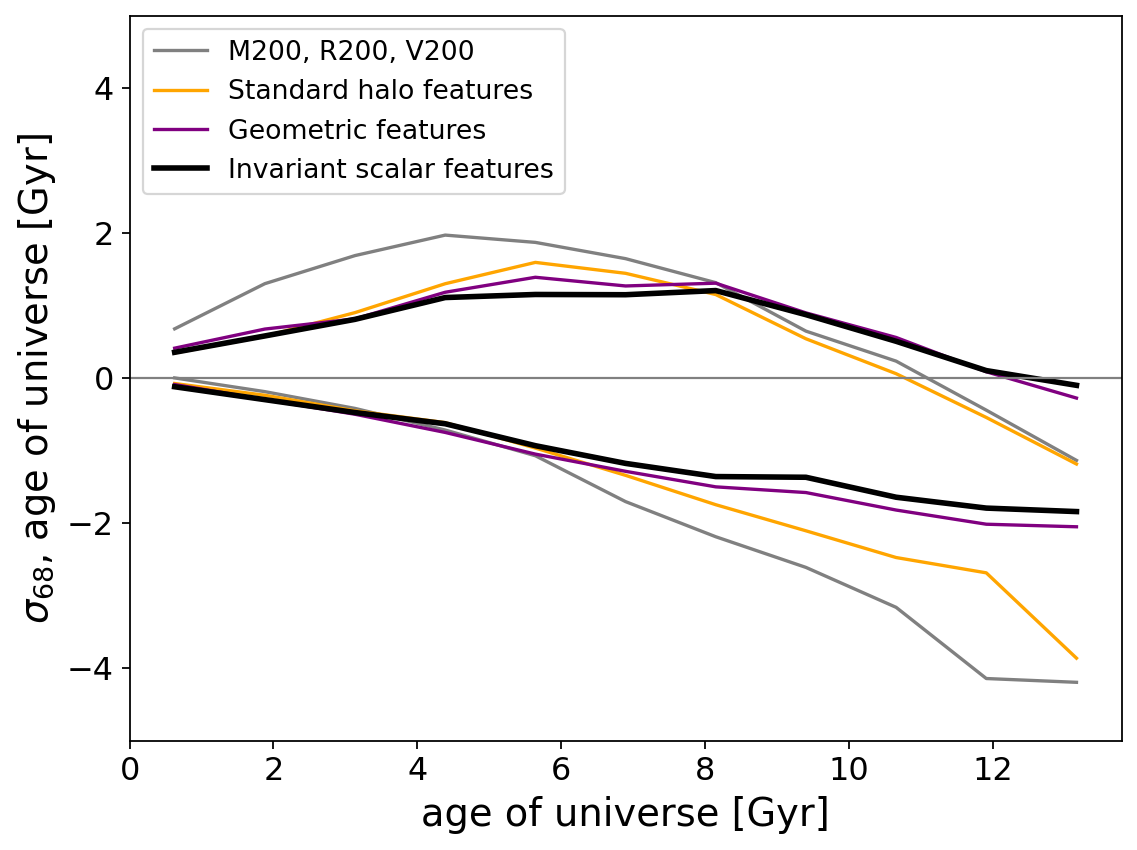

In [216]:
plt.figure(figsize=(8,6))
ax = plt.gca()
plotter.plot_errors_vs_a(ax, y_pred_arr, y_test, feature_labels, colors, 
                              lws=lws, legend_loc='upper left',
                              convert_to_Gyr=True)

Text(0, 0.5, 'age of universe(Gyr)')

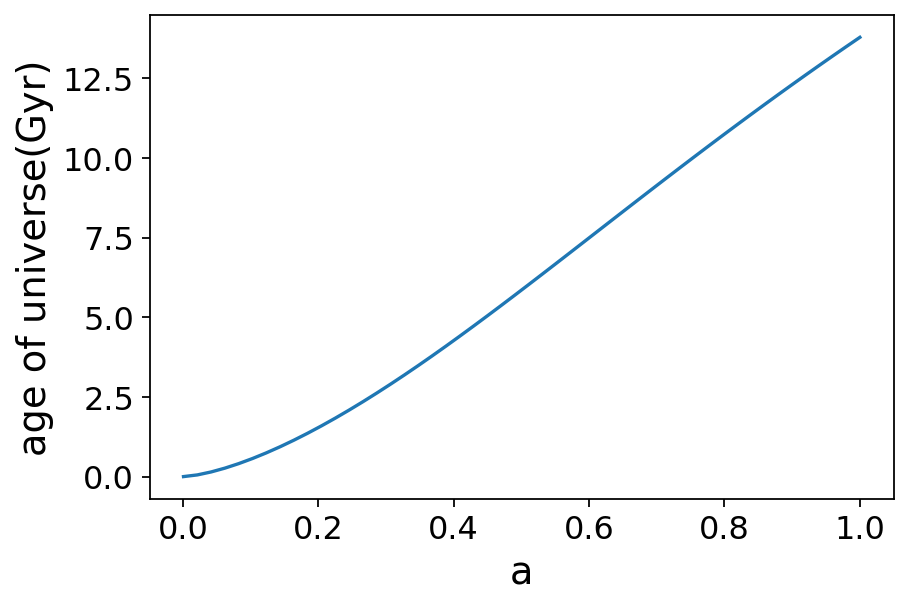

In [184]:
from astropy.cosmology import Planck18, z_at_value
cosmo = Planck18
def a_to_Gyr(a):
    assert not np.any(a==0), "Can't handle zeros rn"
    z = 1/a - 1
    return cosmo.age(z).value # returns in Gyr
a_vals = np.linspace(0.001, 1, 50)
Gyr_vals = a_to_Gyr(a_vals)

plt.plot(a_vals, Gyr_vals)
plt.xlabel("a")
plt.ylabel("age of universe(Gyr)")

TODO: could improve scale factor w limiting to 0-1 with a sigmoid or something??

In [195]:
y_pred_arr.shape

(4, 2951, 39)

In [197]:
print((y_pred_arr.shape[0]*y_pred_arr.shape[1]*y_pred_arr.shape[2]))
print(0.999784949039439*(y_pred_arr.shape[0]*y_pred_arr.shape[1]*y_pred_arr.shape[2]))

460356
460257.0


In [199]:
np.max(y_pred_arr), np.min(y_pred_arr)

(1.522555254110653, -1.487540420204774)

## mean

IndexError: list index out of range

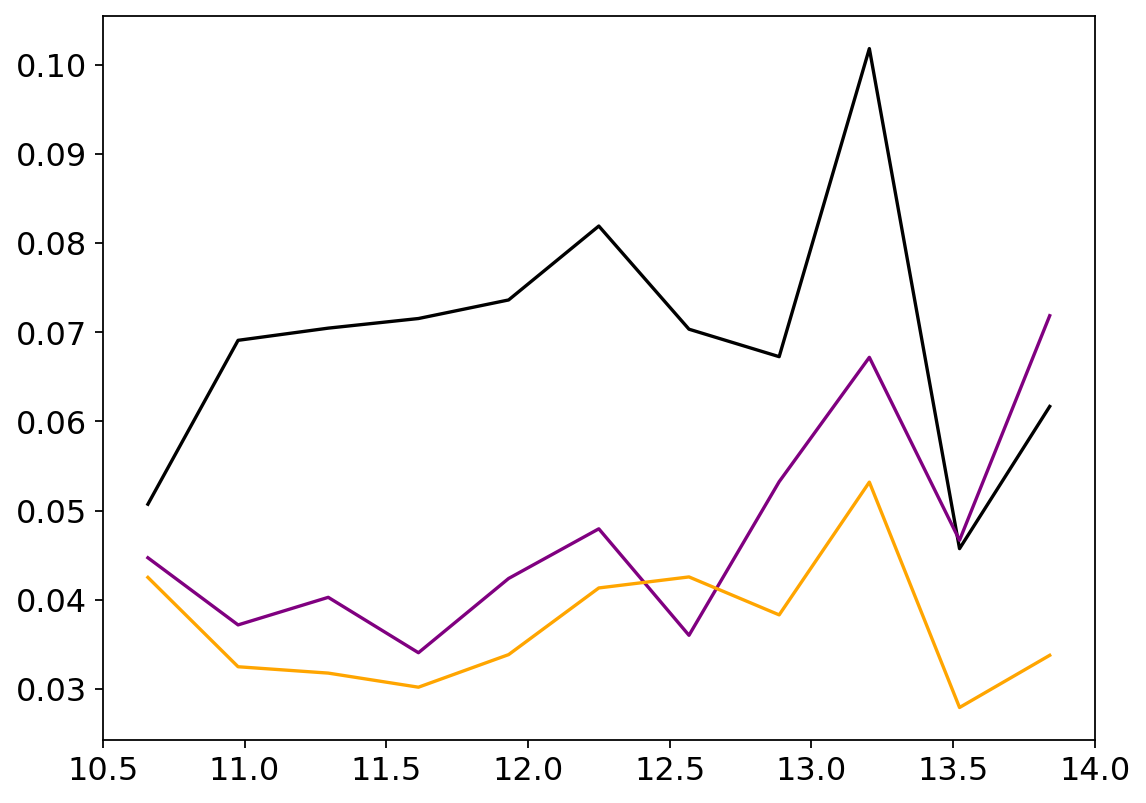

In [105]:
x_label_name = 'm_200m'
x_property = log_m_200m[idx_test] + log_mass_shift
y_label_name_mfrac = rf'mean $M/M_{{a=1}}$'
colors = ['black', 'purple', 'orange']

plt.figure(figsize=(8,6))
ax = plt.gca()

plotter.plot_errors_vs_property(ax, x_label_name, y_label_name_mfrac, x_property, y_test_mavg, y_pred_mavg_arr, 
                       feature_labels, colors, lws=lws)

## Function of mfrac (blow up bottom panel)

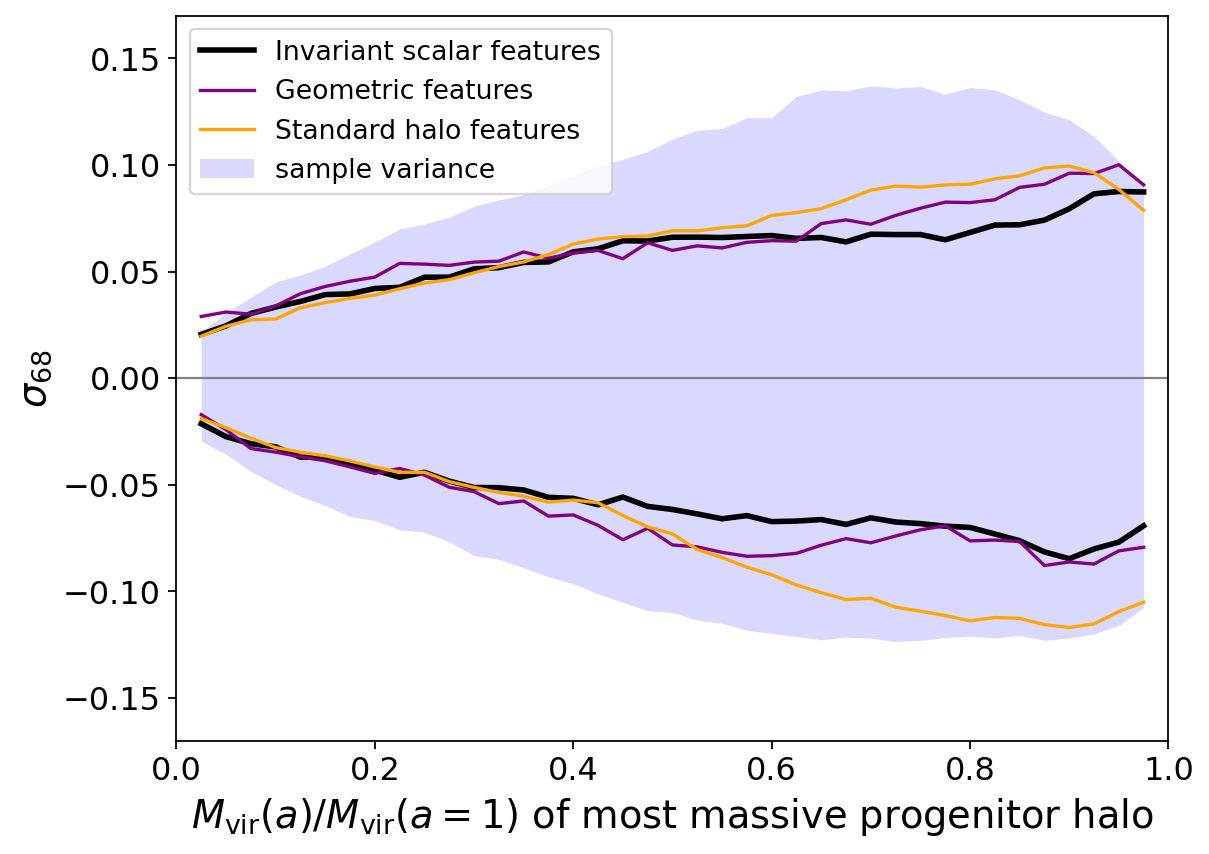

In [107]:
plt.figure(figsize=(8,6))
ax = plt.gca()
plotter.plot_errors_vs_mfracs(ax, y_pred_arr, y_test, mfrac_vals, feature_labels, colors, 
                              lws=lws, legend_loc='upper left')

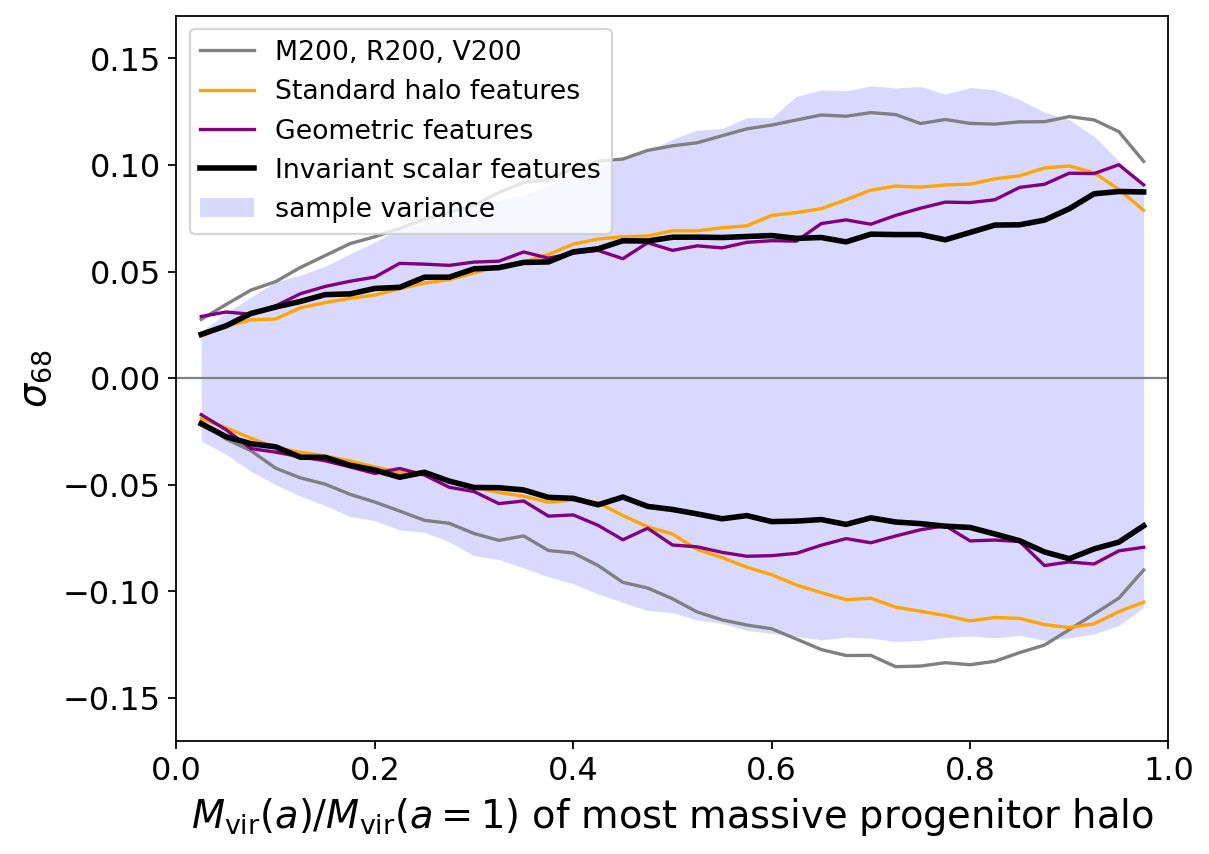

In [120]:
plt.figure(figsize=(8,6))
ax = plt.gca()
plotter.plot_errors_vs_mfracs(ax, y_pred_arr, y_test, mfrac_vals, feature_labels, colors, 
                              lws=lws, legend_loc='upper left')

In [123]:
print(y_test[0])
print(y_test[1])

[0.24081618 0.28856151 0.31118234 0.33599293 0.39283528 0.40023231
 0.40606071 0.41193357 0.42077698 0.42635096 0.42954783 0.43274469
 0.46586857 0.48348777 0.51317062 0.54866012 0.56041849 0.57168846
 0.58104324 0.59043815 0.59578249 0.59996174 0.60392451 0.60788729
 0.61790617 0.62460045 0.63220201 0.64089771 0.64916354 0.65599729
 0.66428545 0.67677358 0.7012799  0.95226805 0.96162243 0.96929442
 0.97440092 0.98179158 0.99089613]
[0.21848433 0.23973617 0.25763261 0.27559142 0.29018088 0.30880115
 0.33053328 0.3460938  0.35324481 0.36817661 0.37982897 0.39557305
 0.41321895 0.46524062 0.47846725 0.49330905 0.50820614 0.51938407
 0.5306089  0.5397662  0.5501053  0.56473156 0.59126735 0.60576466
 0.61463067 0.62320167 0.64088524 0.67202361 0.6886612  0.70204187
 0.719542   0.74671214 0.77593937 0.82054052 0.85159485 0.87260438
 0.93967713 0.97360693 0.99147621]


TypeError: plot_errors_vs_property() missing 2 required positional arguments: 'y_pred_labels' and 'colors'

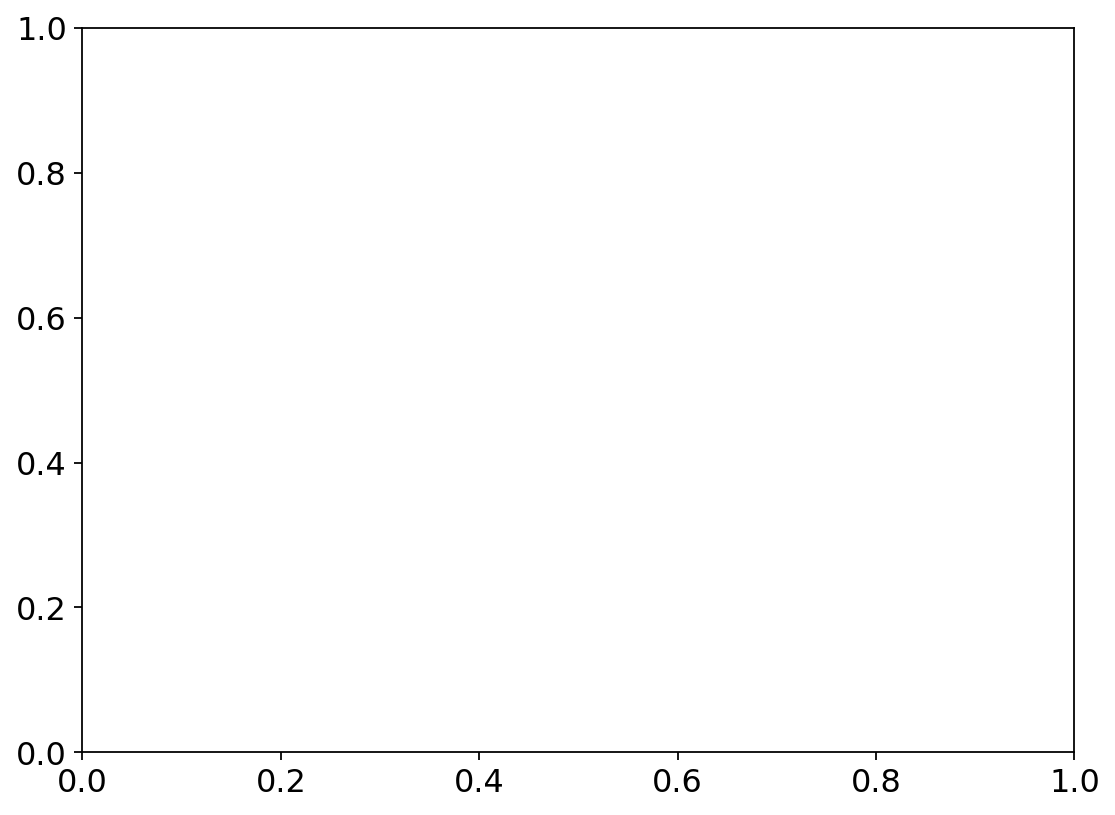

In [125]:
plt.figure(figsize=(8,6))
ax = plt.gca()
plotter.plot_errors_vs_property(ax, y_pred_arr, y_test, y_test, feature_labels, colors, 
                              lws=lws)

# Num mergers

In [108]:
x_label_name = 'm_200m'
y_label_name = 'num_mergers'
fit_tag = f'_elementary_{y_label_name}_nn_scalars_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [110]:
y_pred = np.load(fn_pred)
print(y_pred.shape)

(2951,)


In [117]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:360: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  return newcmap


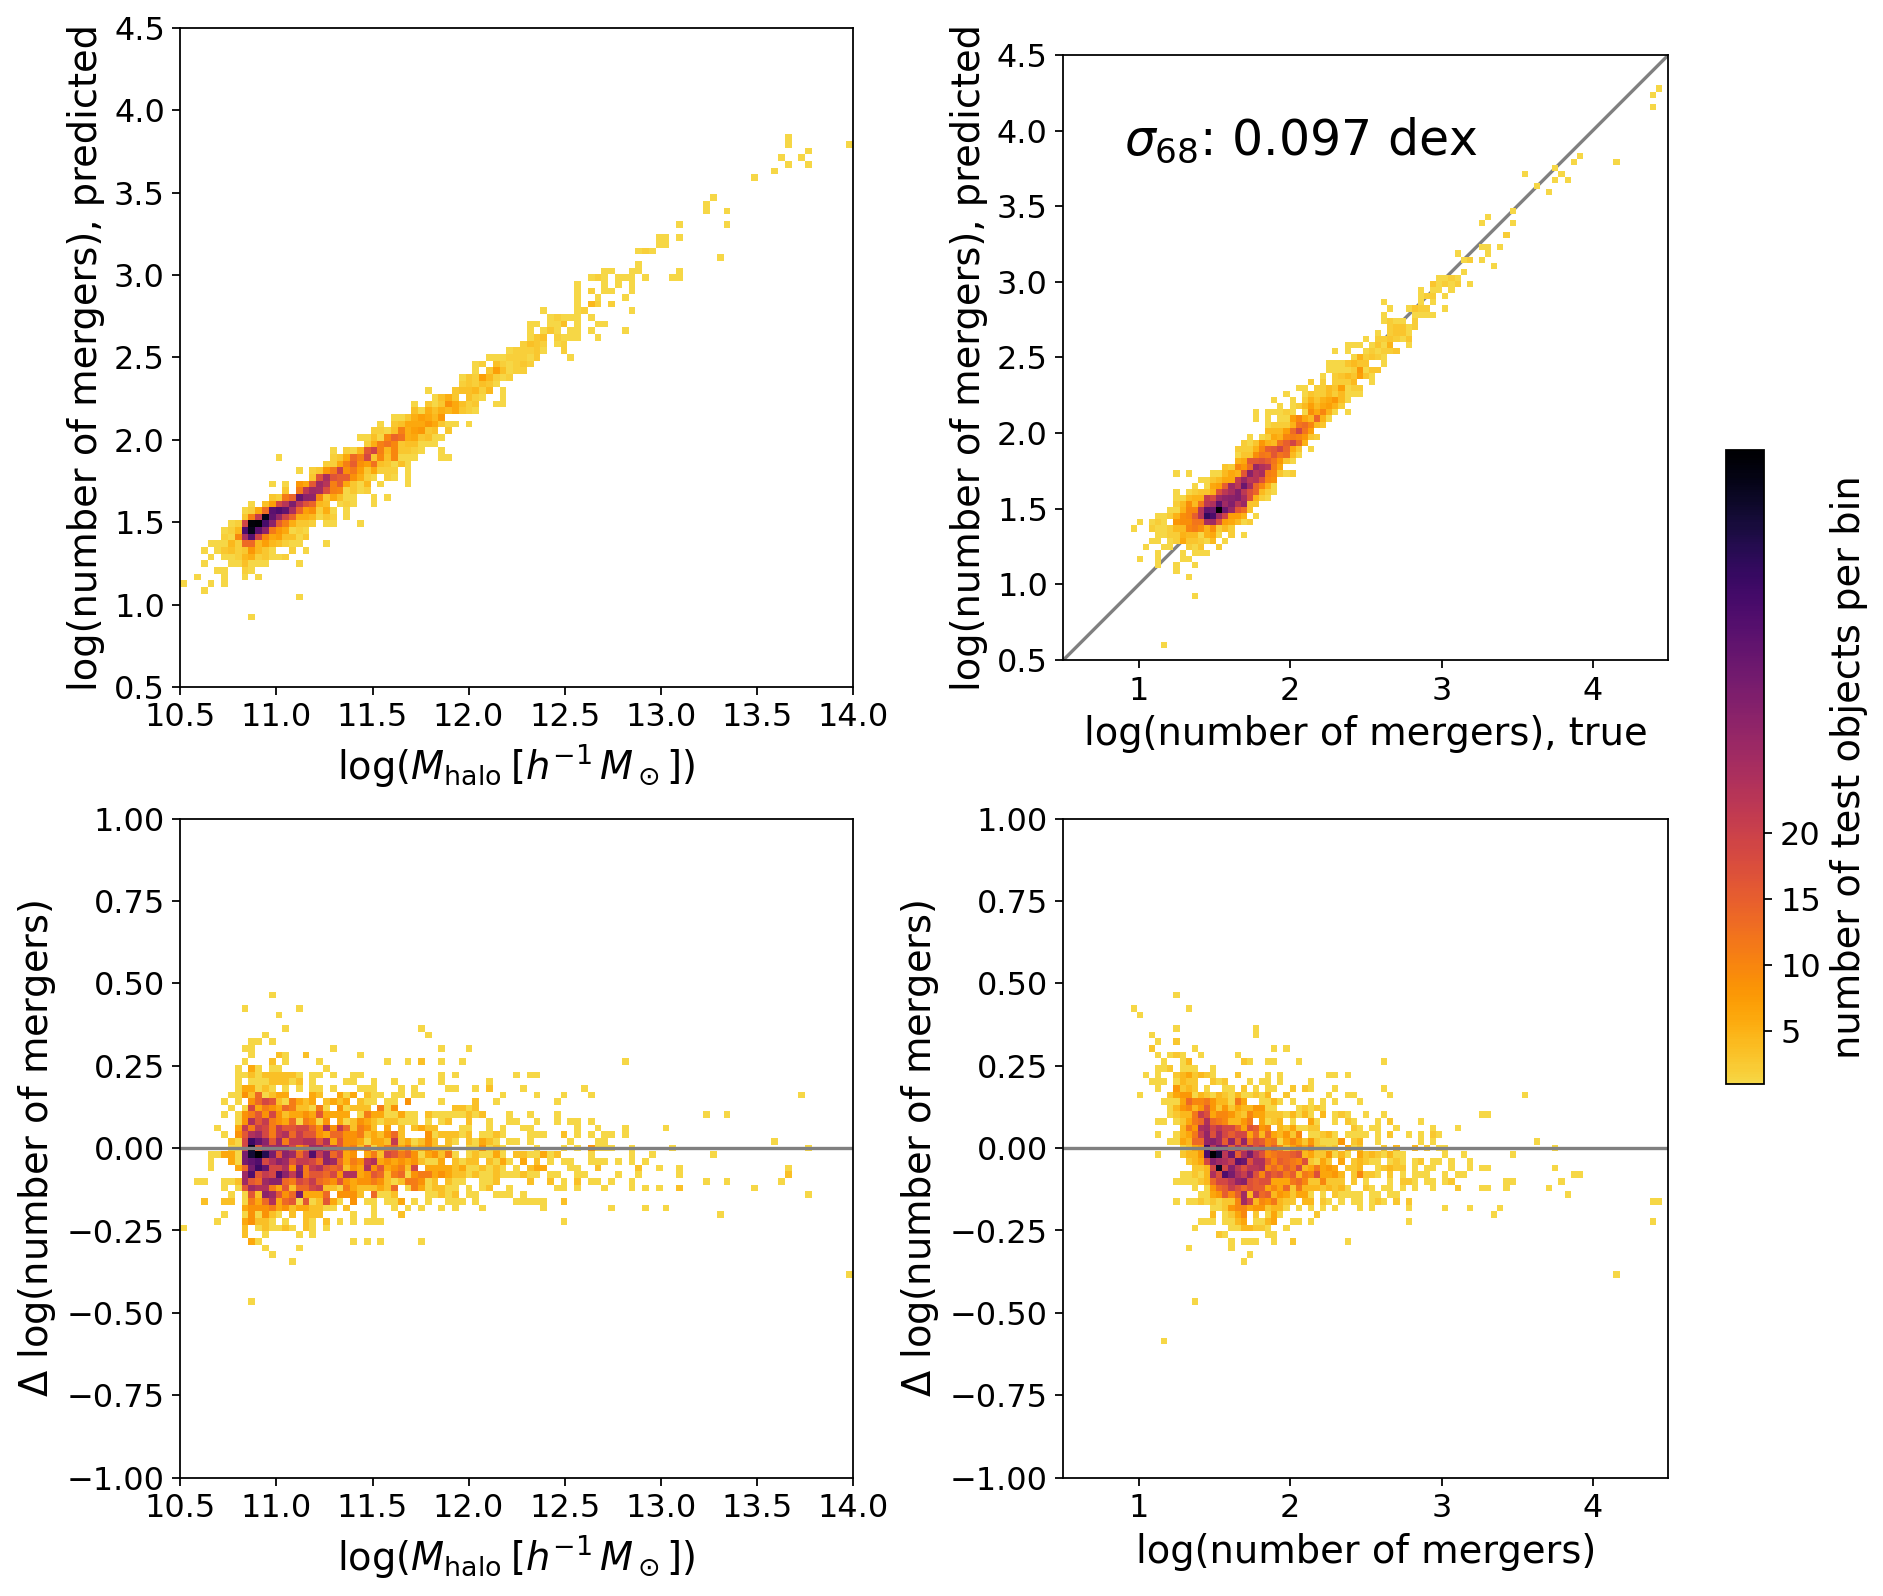

In [119]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test, y_pred, 
                              text_results=error_str)

In [8]:
y_label_name = 'num_mergers'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
feature_modes = ['scalars', 'geos', 'catalog_z0']

In [13]:
feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]

In [9]:
y_pred_arr = []
for i, feature_mode in enumerate(feature_modes):
    fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    if feature_mode=='scalars':
        fit_tag = '_elementary'+fit_tag
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

    y_pred = np.load(fn_pred)
    y_pred_arr.append(y_pred)

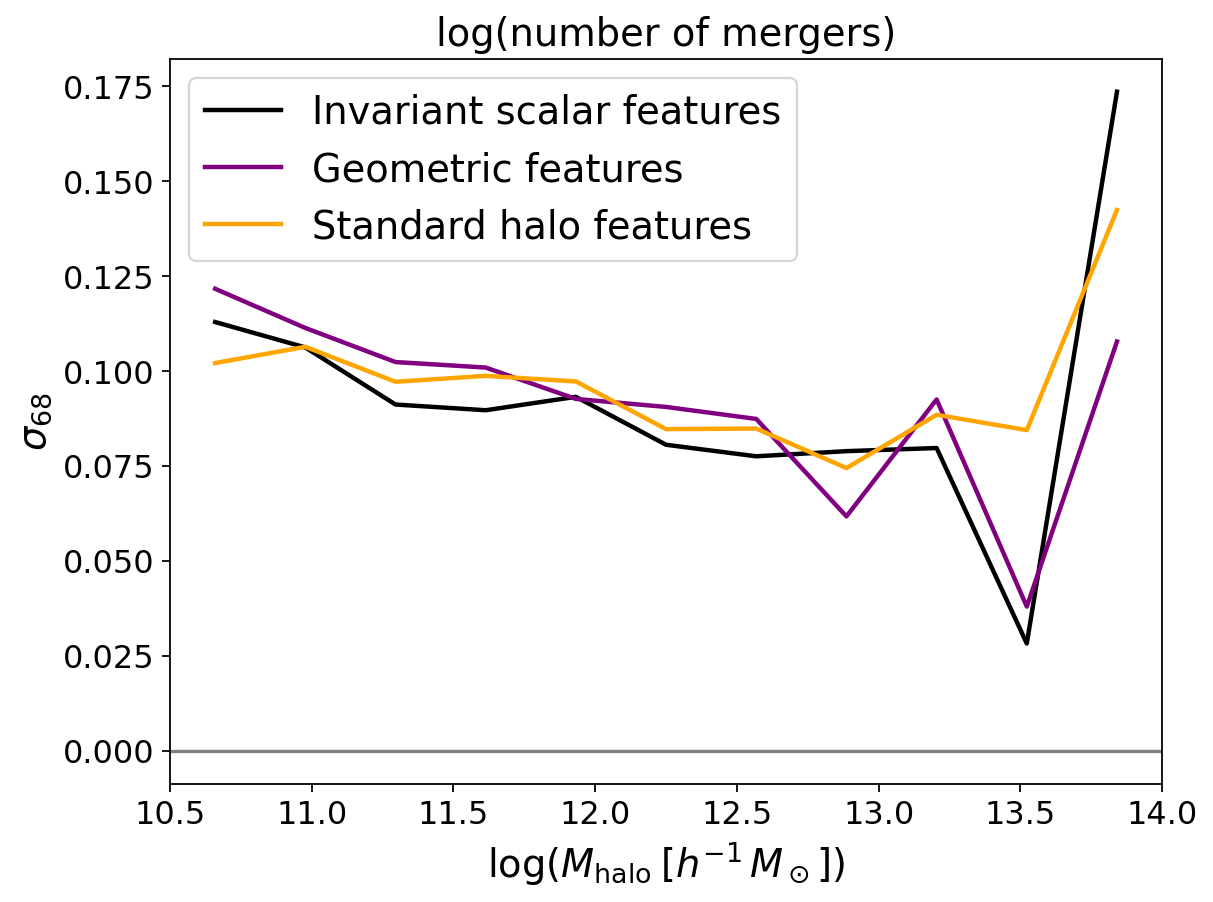

In [15]:
x_label_name = 'm_200m'
x_property = log_m_200m[idx_test] + log_mass_shift
colors = ['black', 'purple', 'orange']

plt.figure(figsize=(8,6))
ax = plt.gca()
x_property = log_m_200m[idx_test] + log_mass_shift
plotter.plot_errors_vs_property(ax, x_label_name, y_label_name, x_property, y_test, y_pred_arr, 
                       feature_labels, colors)

## Multi label

In [8]:
x_label_name = 'm_200m'
#y_label_name_arr = ['ssfr1', 'r_stellar', 'gband', 'bhmass_per_mstellar', 'j_stellar']

y_label_name_plot = ['ssfr1', 'r_stellar', 'gband_minus_iband', 'bhmass_per_mstellar', 'j_stellar']
y_label_name_arr = ['m_stellar', 'ssfr1', 'r_stellar', 'gband_minus_iband', 'bhmass_per_mstellar', 'j_stellar']
y_label_name_train = '_'.join(y_label_name_arr)
fit_tag = f'_{y_label_name_train}_nn_scalars_epochs1000_lr5e-05_hs128'

# fit_tags = {'ssfr1': '_ssfr1_nn',
#             'r_stellar': '_r_stellar_nn',
#             'gband': '_gband_nn_scalars_epochs500_lr5e-05_hs128',
#             'bhmass_per_mstellar': '_bhmass_per_mstellar_nn_scalars_epochs500_lr5e-05_hs128',
#             'j_stellar': '_j_stellar_nn_scalars_epochs500_lr5e-05_hs128',
#            }

y_true_arr = []
y_pred_arr = []
text_results_arr = []

feature_mode = 'scalars'
#fit_tag = fit_tags[y_label_name]
if feature_mode=='scalars':
    fit_tag = '_elementary'+fit_tag
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'


y_pred_all = np.load(fn_pred)
for y_label_name in y_label_name_plot:
    i = y_label_name_arr.index(y_label_name)
    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]
    y_pred = y_pred_all[:,i]
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    y_true_arr.append(y_test)
    y_pred_arr.append(y_pred)
    text_results_arr.append(error_str)
    
x_property = log_m_200m[idx_test] + log_mass_shift

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  def log_sfr_to_log_ssfr(log_sfr_arr, m_stellar_arr, mass_multiplier=1e10):


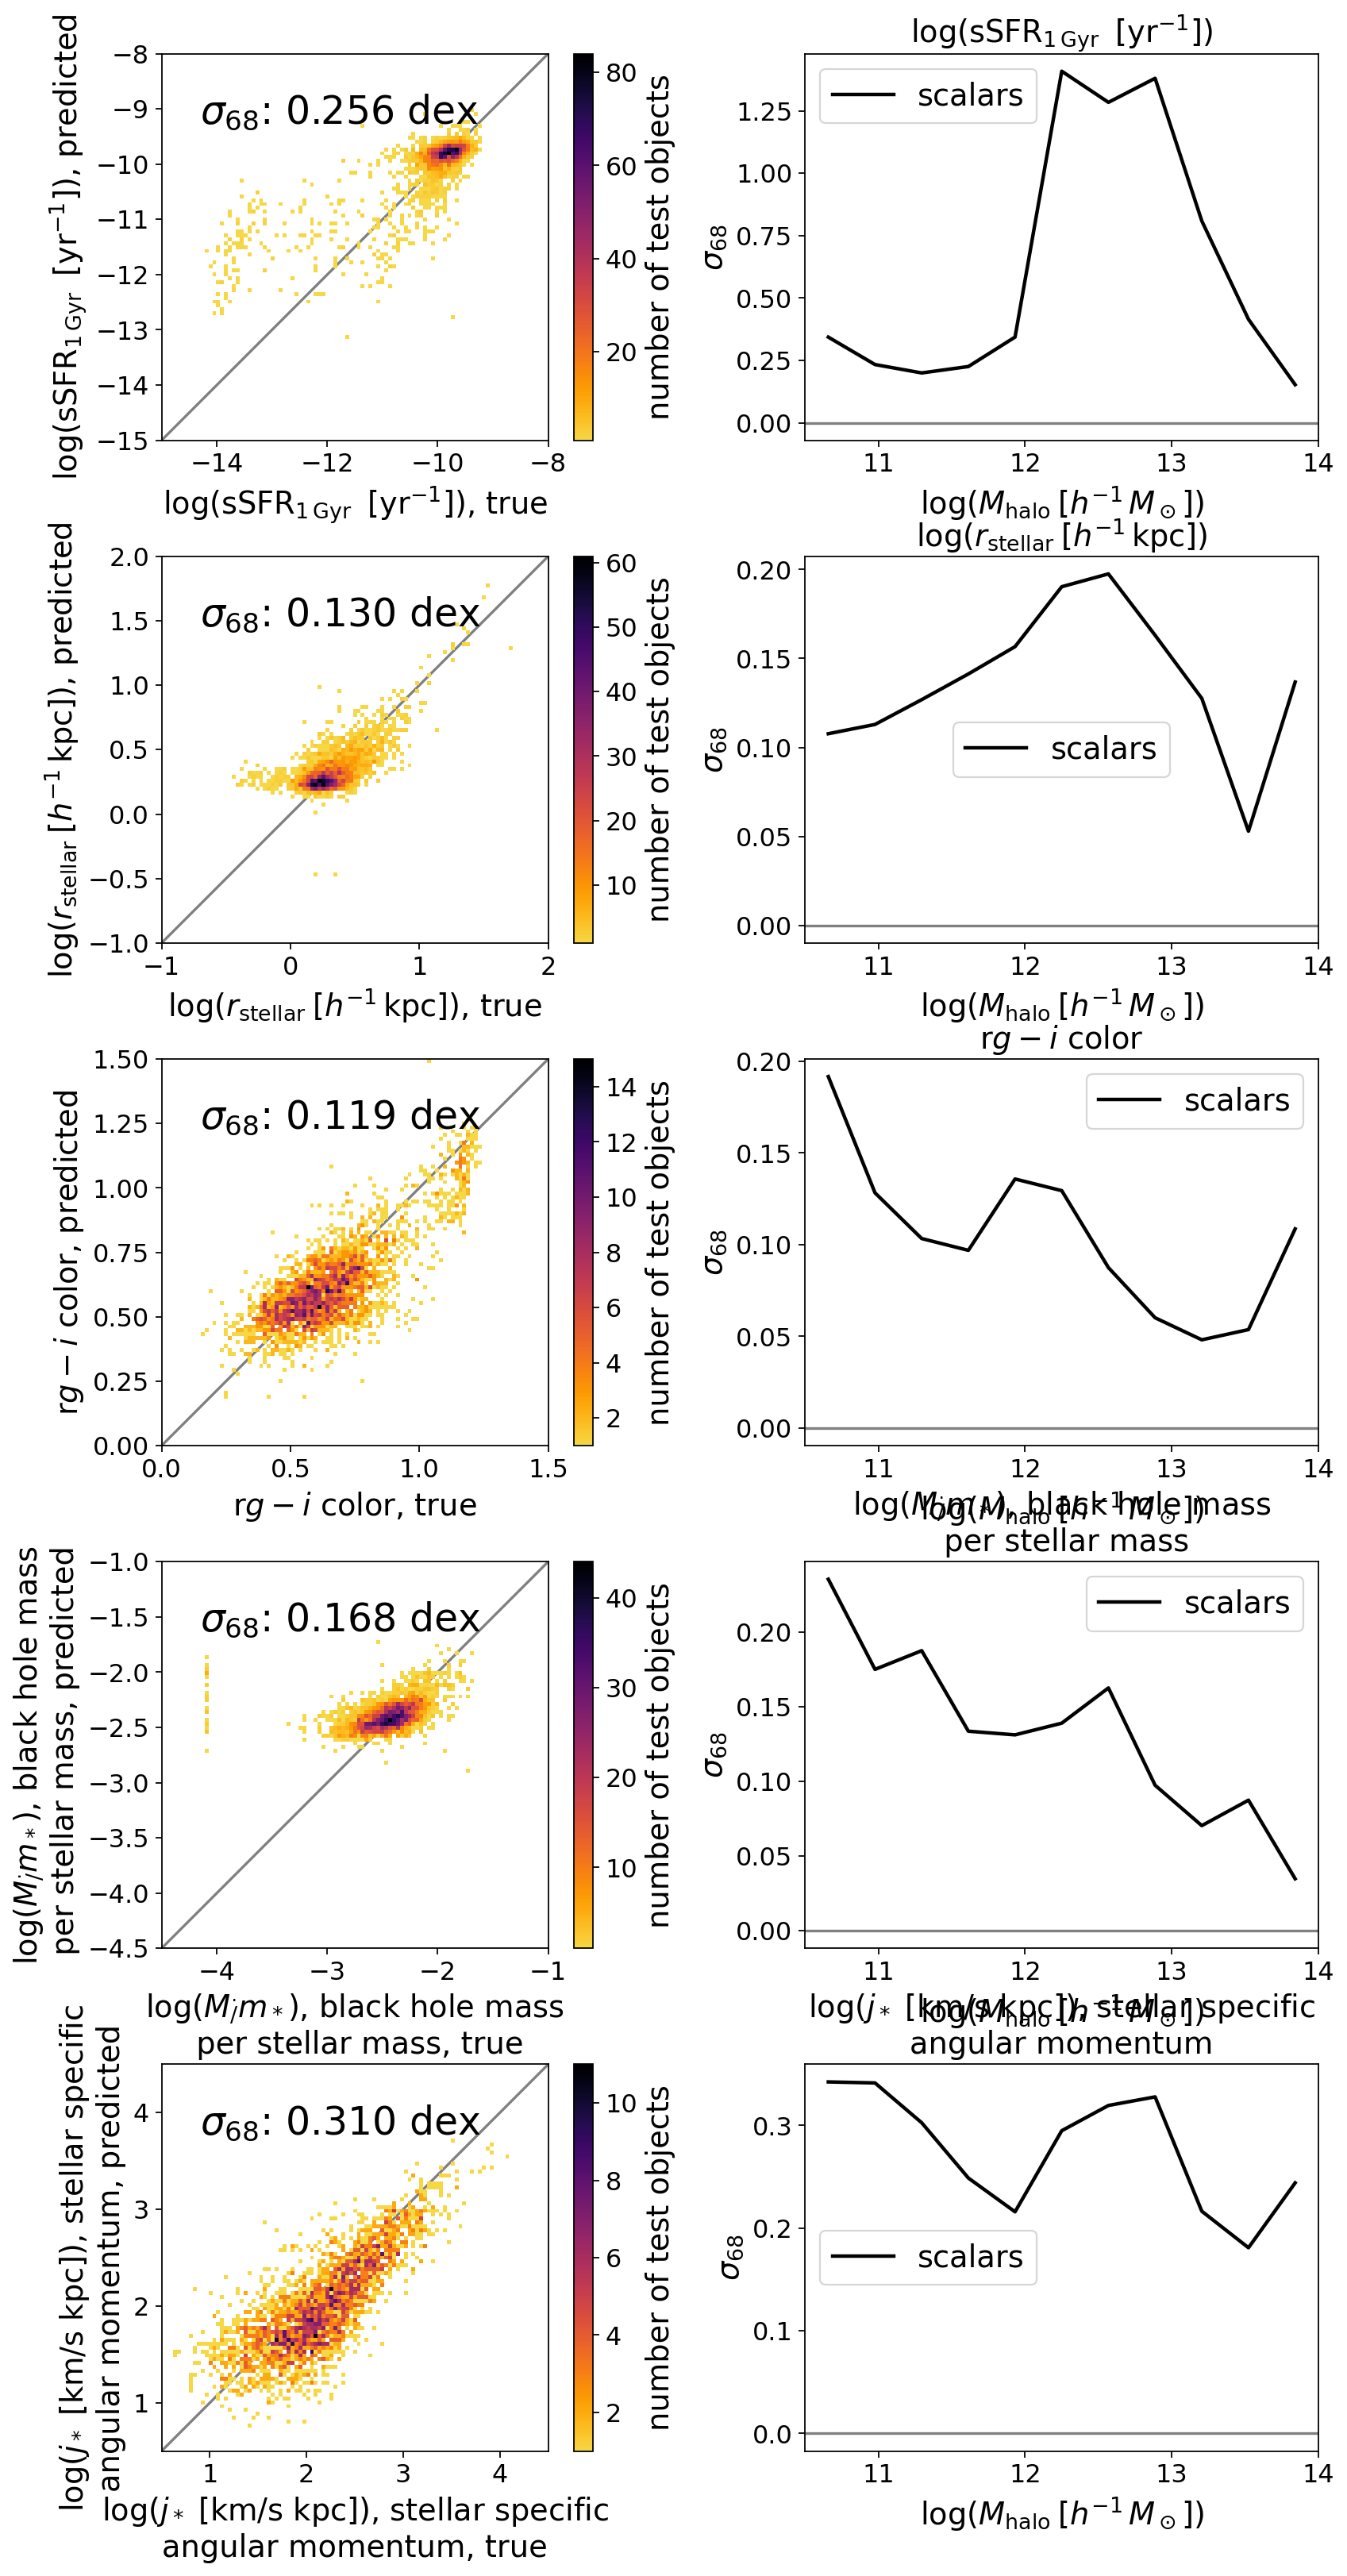

In [70]:
plotter.plot_multi_panel_gal_props(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                      text_results_arr=text_results_arr)

### Butterfly

In [30]:
x_label_name = 'm_200m'
y_label_name = 'r_stellar'
x_bins_avg, stdevs_binned = utils.get_butterfly_error(x_label_name, y_label_name, halo_logmass_min=10.8, n_bins=10)

(731, 8)
Assuming y is logscale! (CHECK)


Text(0, 0.5, 'stdev of pairwise diffs / $\\sqrt{2}$')

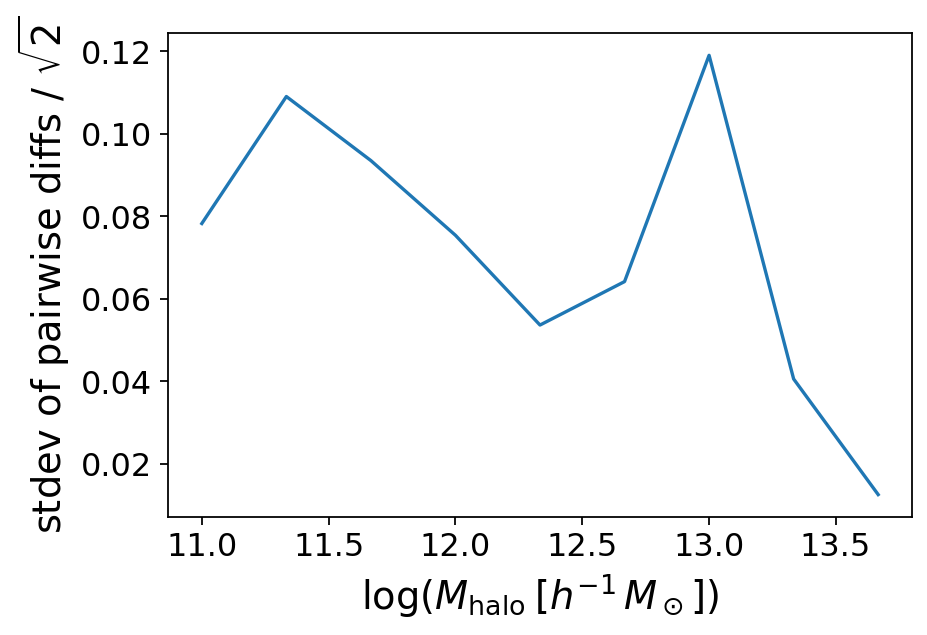

In [31]:
plt.plot(x_bins_avg, stdevs_binned)
plt.xlabel(utils.get_label('m_200m'))
plt.ylabel(r'stdev of pairwise diffs / $\sqrt{2}$')

### Full plot

In [25]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']

feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
print(feature_labels)

['Invariant scalar features', 'Geometric features', 'Standard halo features', 'M200, R200, V200']


In [102]:
x_label_name = 'm_200m'
#y_label_name_arr = ['ssfr1', 'r_stellar', 'gband', 'bhmass_per_mstellar', 'j_stellar']

#y_label_name_plot = ['ssfr1', 'r_stellar', 'gband_minus_iband', 'bhmass_per_mstellar', 'j_stellar']
y_label_name_plot = ['m_stellar', 'ssfr1', 'r_stellar', 'bhmass_per_mstellar']


y_label_name_arr = ['m_stellar', 'ssfr1', 'r_stellar', 'gband_minus_iband', 'bhmass_per_mstellar', 'j_stellar']
y_label_name_train = '_'.join(y_label_name_arr)

y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars')

y_pred_feat_arr = []
for j in range(len(feature_labels)):
    feature_mode = feature_modes[j]
    fit_tag = f'_{y_label_name_train}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    #fit_tag = fit_tags[y_label_name]
    if feature_mode=='scalars':
        fit_tag = '_elementary'+fit_tag
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    y_pred_feat_arr.append(y_pred_all)
    
y_pred_feat_arr = np.array(y_pred_feat_arr)
print(y_pred_feat_arr.shape)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_name_arr.index(y_label_name)
    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    if y_label_name=='m_stellar':
        y_test += log_mass_shift
        y_pred_feats += log_mass_shift
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    x_bins, stdevs_binned = utils.get_butterfly_error(x_label_name, y_label_name, halo_logmass_min=10.8, n_bins=10)
    y_lowerlim_arr.append(stdevs_binned)
    
    y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
print(y_pred_arr.shape)
x_property = log_m_200m[idx_test] + log_mass_shift

(4, 2951, 6)
Assuming y is logscale! (CHECK)
Assuming y is logscale! (CHECK)
Assuming y is logscale! (CHECK)
Assuming y is logscale! (CHECK)
(4, 4, 2951)


In [103]:
frac_test = len(idx_test)/len(sim_reader.dark_halo_arr)
L_Mpc = sim_reader.box_size / 1000.0
weight = 1/(L_Mpc**3 * frac_test)
colorbar_label = r'$\bar{n}$ per dex [1/(($h^{-1}$ Mpc)$^3$ dex)]'

In [104]:
colors = ['black', 'maroon', 'lightseagreen', 'springgreen']

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


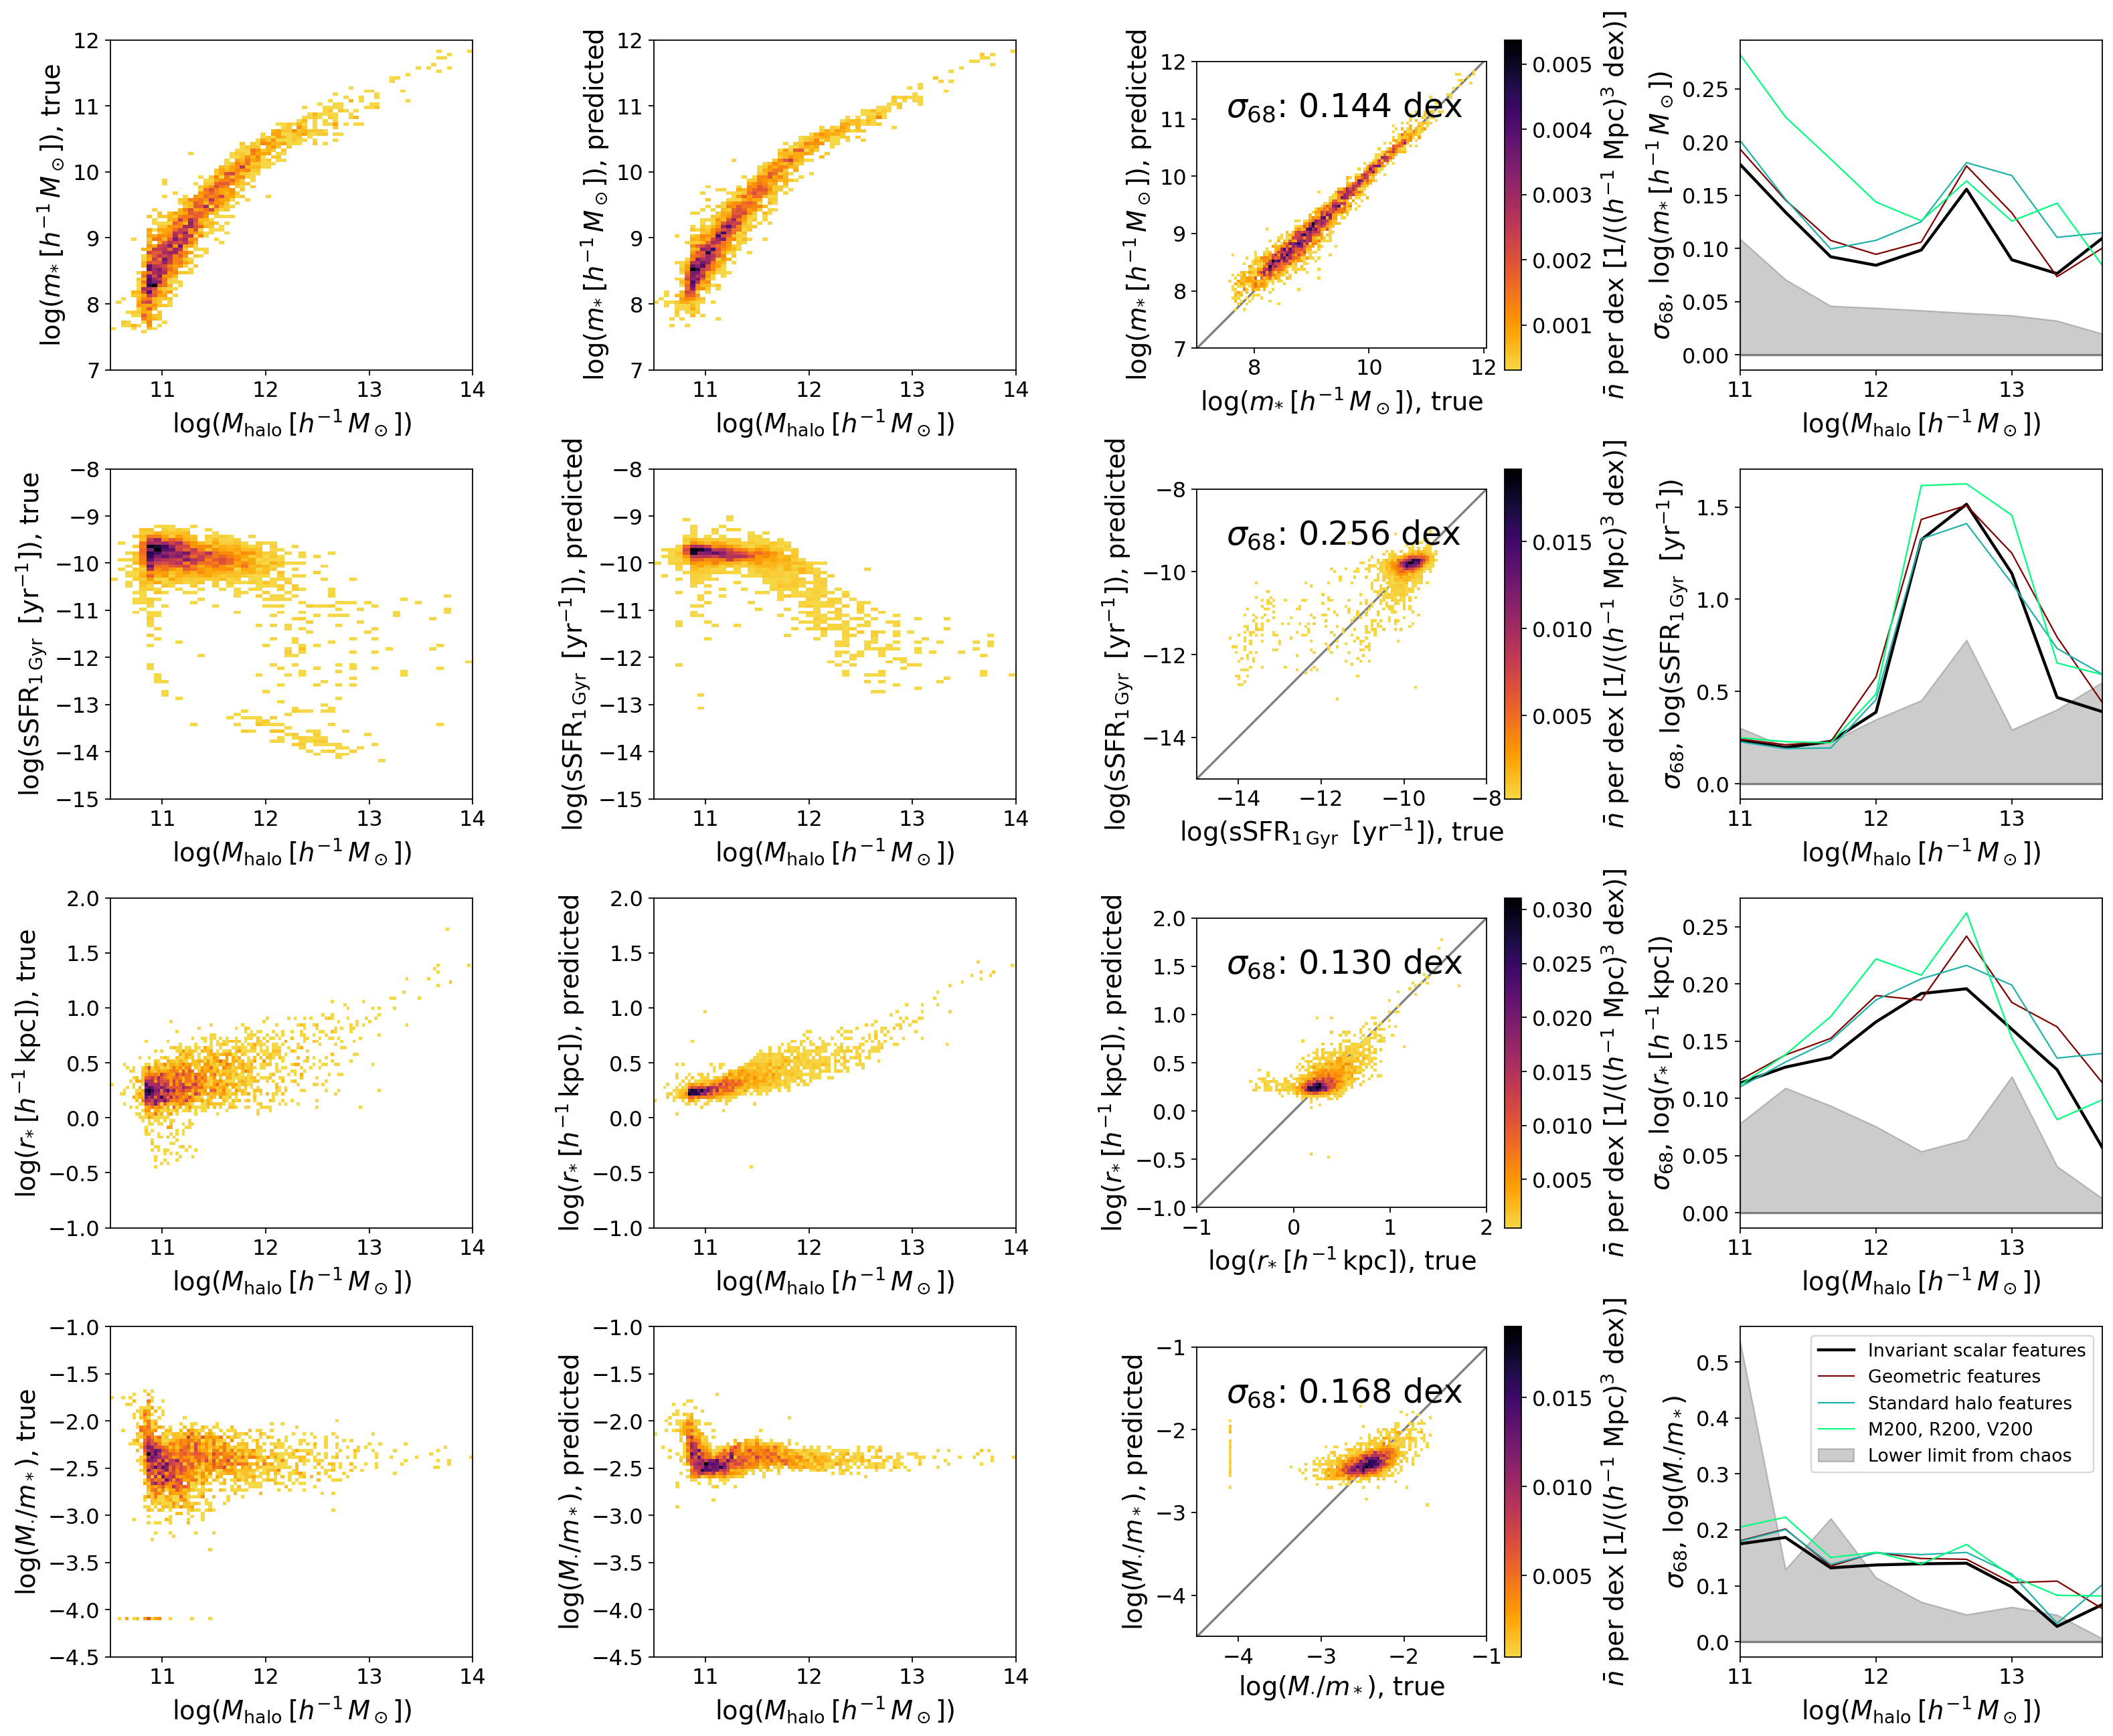

In [109]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)

## Compare halo selections

In [17]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = '_Mmin10_nstar1'
mass_multiplier = 1e10
log_mass_shift = 10

In [18]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)

../configs/halos_TNG100-1_Mmin10_nstar1.yaml


In [19]:
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

# Load in objects; need no matter what feature type
sim_reader = SimulationReader(halo_params['sim']['base_dir'], halo_params['sim']['sim_name'], 
                              halo_params['sim']['sim_name_dark'], halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(halo_params['halo']['fn_dark_halo_arr'])
sim_reader.read_simulations() # TODO: do we need this step?

In [20]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

In [21]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [22]:
feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}

In [23]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
feature_modes = ['catalog_z0']
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
print(feature_labels)

['Standard halo features']


In [24]:
halo_tag = '_Mmin10_nstar1'

In [25]:
y_pred_arr = []
text_results_arr = []
for i, feature_mode in enumerate(feature_modes):
    fit_tag = f'_{y_label_name}_hgboost_{feature_mode}_epochs300_lr0.1_hs128'
    if feature_mode=='scalars':
        fit_tag = '_elementary'+fit_tag
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

    y_pred = np.load(fn_pred)
    y_pred_mult = y_pred + log_mass_shift
    y_pred_arr.append(y_pred_mult)
    
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    text_results_arr.append(error_str)

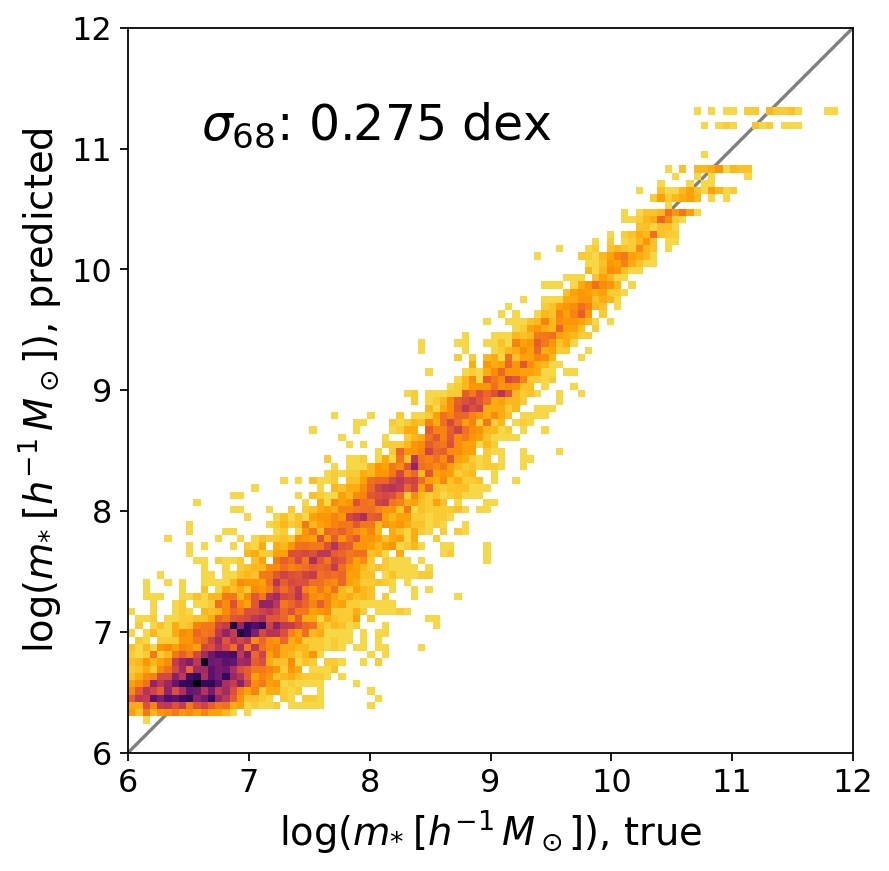

In [31]:
for i in range(len(y_pred_arr)):
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    y_pred = y_pred_arr[i]
    plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred, cmap_hist, text_results=text_results_arr[i],
                                   x_lim=(6,12), y_lim=(6,12))